In [2]:
import pandas as pd
import numpy as np
from numpy import median
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
data_path = "C:/Users/armcl/Python/Springboard_Cap1/Data/" 

In [4]:
#Read Redfin data
redfin = pd.read_csv(data_path + "Redfin/Santa_Clara_County.csv")
#Remove irrelvant and poor quality (for example 'DAYS ON MARKET') data columns
redfin_col_to_drop = ['SALE TYPE', 'DAYS ON MARKET', 'STATUS', 'NEXT OPEN HOUSE START TIME', 
                       'NEXT OPEN HOUSE END TIME', 'SOURCE', 'FAVORITE', 'INTERESTED', 
                       'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
                               'LOCATION', 'MLS#', '$/SQUARE FEET', 'ADDRESS']
redfin = redfin.drop(columns = redfin_col_to_drop)

In [5]:
#More wrangling on outliers
#Only include property types that are intersting and have enough data
#Didn't exclude multi-family (2-4 unit) because some of them are actually very similar to single family house
redfin_filtered = redfin[redfin['PROPERTY TYPE'].isin(['Condo/Co-op','Multi-Family (2-4 Unit)',
                                                      'Single Family Residential',
                                                      'Townhouse'])]
#Make quarter dummy variables
redfin_filtered = redfin_filtered.dropna(subset=['SOLD DATE'])
redfin_filtered['QUARTER'] = pd.to_datetime(redfin_filtered['SOLD DATE']).dt.quarter
redfin_filtered = pd.concat([redfin_filtered, pd.get_dummies(redfin_filtered['QUARTER'],
                                                             prefix="Q")], axis=1)  

In [6]:
#Segmenting by num of beds does not make much difference; will just use median for all beds

HOA_BY_TYPE = redfin_filtered.groupby('PROPERTY TYPE').median()['HOA/MONTH'].to_frame()

#Replace NaN HOA with median based on property type

redfin_filtered.loc[(redfin_filtered['HOA/MONTH'].isnull()) &
                    (redfin_filtered['PROPERTY TYPE'] == 'Single Family Residential'),
                    'HOA/MONTH'] = HOA_BY_TYPE.loc['Single Family Residential','HOA/MONTH']

redfin_filtered.loc[(redfin_filtered['HOA/MONTH'].isnull()) &
                    (redfin_filtered['PROPERTY TYPE'] == 'Condo/Co-op'),
                    'HOA/MONTH'] = HOA_BY_TYPE.loc['Condo/Co-op','HOA/MONTH']

redfin_filtered.loc[(redfin_filtered['HOA/MONTH'].isnull()) &
                    (redfin_filtered['PROPERTY TYPE'] == 'Townhouse'),
                    'HOA/MONTH'] = HOA_BY_TYPE.loc['Townhouse','HOA/MONTH']

redfin_filtered.loc[(redfin_filtered['HOA/MONTH'].isnull()) &
                    (redfin_filtered['PROPERTY TYPE'] == 'Multi-Family (2-4 Unit)'),
                    'HOA/MONTH'] = HOA_BY_TYPE.loc['Multi-Family (2-4 Unit)','HOA/MONTH']


In [7]:
#Remove observations with states not in CA (data errors)
redfin_filtered = redfin_filtered.loc[redfin_filtered['STATE OR PROVINCE'] == 'CA',:]

#Remove observations with extreme or NAN beds, baths, square feet, lot size, year built
#Note: lot size can be 0 for example condos or townhouses
redfin_filtered = redfin_filtered[(redfin_filtered['PRICE'] > 100000) & (redfin_filtered['BEDS'] > 0) & 
(redfin_filtered['BATHS'] > 0) & (redfin_filtered['SQUARE FEET'] > 10) & 
(redfin_filtered['LOT SIZE'].notnull()) & (redfin_filtered['YEAR BUILT'] > 0)] 

#Some zipcodes are not in 5 digit formats
redfin_filtered['ZIP OR POSTAL CODE'] = redfin_filtered['ZIP OR POSTAL CODE'].str[:5]

#Add a column which is the total size of living square feet and lot
redfin_filtered['TOTAL SIZE'] = redfin_filtered['SQUARE FEET'] + redfin_filtered['LOT SIZE']

#Drop columns that are not relevant anymore
redfin_filtered = redfin_filtered.drop(columns = ['STATE OR PROVINCE'])

#number of inventory will decide price (supply/demand)
#use the number of sales in each zip code to proxy inventory

sale_num_zip = redfin_filtered.groupby('ZIP OR POSTAL CODE').size().to_frame(name='sale_num_zip')
redfin_filtered = pd.merge(redfin_filtered, sale_num_zip, left_on = ['ZIP OR POSTAL CODE'], 
                      right_index=True, how='left')

#Drop duplicates (due to downloading constraints)
redfin_filtered = redfin_filtered.drop_duplicates()

In [8]:
#Check the 1st, 10th, 90th, and 99th percentiles see if any outliers
redfin_filtered.quantile([.01, .1, .9, .99])

PRICE  BEDS  BATHS  SQUARE FEET  LOT SIZE  YEAR BUILT  HOA/MONTH  \
0.01   450000.0   1.0    1.0       692.00    444.81      1910.0      34.00   
0.10   682000.2   2.0    1.5      1004.00   1018.10      1951.0     117.00   
0.90  2395000.0   4.0    3.5      2760.00  11568.80      2007.0     404.00   
0.99  4700000.0   6.0    5.0      5019.33  90604.00      2018.0     728.76   

       LATITUDE   LONGITUDE  QUARTER  Q_1  Q_2  Q_3  Q_4  TOTAL SIZE  \
0.01  36.999970 -122.145783      1.0  0.0  0.0  0.0  0.0     1445.00   
0.10  37.205772 -122.056710      1.0  0.0  0.0  0.0  0.0     2277.00   
0.90  37.399131 -121.750126      4.0  1.0  1.0  1.0  1.0    14208.90   
0.99  37.445272 -121.575402      4.0  1.0  1.0  1.0  1.0    94180.68   

      sale_num_zip  
0.01         123.0  
0.10         302.0  
0.90        1147.0  
0.99        1361.0

In [9]:
#Read Airbnb data
#Dictionary: https://rstudio-pubs-static.s3.amazonaws.com/365075_ec9ebe4da4cc465ba9beaef25cda6bad.html

airbnb = pd.read_csv(data_path + "Airbnb/Santa Clara/listings.csv", encoding='utf8')

pd.set_option('display.max_columns', None)

In [10]:
#Keep the relevant columns
airbnb = airbnb[['id', 'last_scraped', 'host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost',
                'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'city', 'state', 'zipcode', 'latitude', 'longitude', 'property_type',
                'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
                'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
                'extra_people', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification',
                'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'reviews_per_month',
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']]


In [11]:
#Read Calendar Data to get the annual average price

airbnb_calendar = pd.read_csv(data_path + "Airbnb/Santa Clara/calendar.csv", encoding='utf8')

airbnb_calendar['price'] = airbnb_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
airbnb_calendar = airbnb_calendar.dropna(subset=['price'])

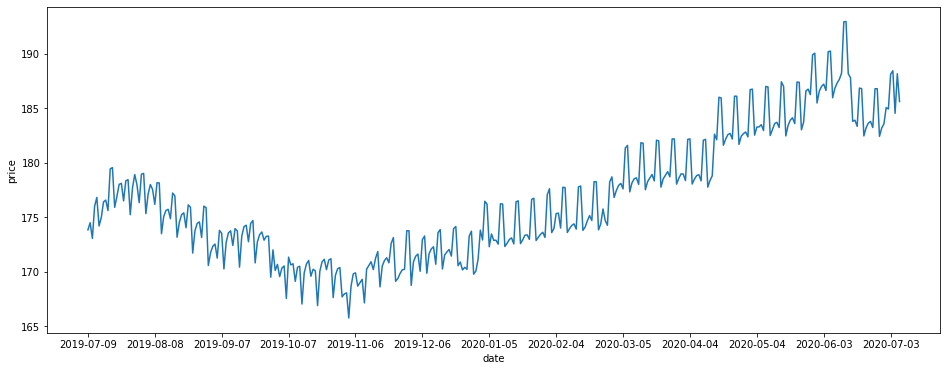

In [12]:
#You can find the weekends' price are higher than weekdays
#Also, late Autumn seems to be a bargin season

plt.figure(figsize=(16, 6))

airbnb_price_ts = airbnb_calendar.groupby('date').mean()
ax = sns.lineplot(x=airbnb_price_ts.index, y="price", data=airbnb_price_ts)

ax.set_xticks(ax.get_xticks()[::30])

plt.show()

In [13]:
#Calendar year average price per listing
avg_price_id = airbnb_calendar.groupby('listing_id').mean()['price']

airbnb = pd.merge(airbnb, avg_price_id, left_on = ['id'], 
                      right_index=True, how='left')

airbnb.rename(columns={'price_y': 'price'}, inplace=True)

airbnb.loc[airbnb['price'].isnull(),'price'] = airbnb['price_x']
airbnb = airbnb.drop(columns='price_x')


In [14]:
#Create a new column: difference between last_scraped and host_since
airbnb['host_days'] = (pd.to_datetime(airbnb['last_scraped']) - pd.to_datetime(airbnb['host_since']))/np.timedelta64(1,'D')

#host_listings_count == 0 doesn't make much sense. will change them to 1
airbnb.loc[airbnb['host_listings_count'] == 0,'host_listings_count'] = 1

#Some listings show 0 beds, but their pictures and texts clearly show beds, will change them to be the same as #of bedrooms and
#at least =1
airbnb.loc[airbnb['beds'] == 0,'beds'] = airbnb.loc[airbnb['beds'] == 0,'bedrooms']
airbnb.loc[airbnb['beds'].isnull(),'beds'] = airbnb.loc[airbnb['beds'].isnull(),'bedrooms']
airbnb.loc[airbnb['beds'] == 0,'beds'] = 1

#Calculate the number of days since the first/last review
airbnb['first_review_days'] = (pd.to_datetime(airbnb['last_scraped']) - pd.to_datetime(airbnb['first_review']))/np.timedelta64(1,'D')
airbnb['last_review_days'] = (pd.to_datetime(airbnb['last_scraped']) - pd.to_datetime(airbnb['last_review']))/np.timedelta64(1,'D')

#Amenities is str type, convert it dummies of amenities
#Remove amenities that are not relevant
airbnb['amenities_list'] = airbnb['amenities'].str[1:-1]
airbnb = pd.concat([airbnb, airbnb['amenities_list'].str.get_dummies(sep=',')], axis=1)

airbnb.columns = airbnb.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('"', '')
airbnb = airbnb.drop(columns = ['amenities', 'amenities_list', 'toilet', '24-hour_check-in', 'accessible-height_bed', 
                               'accessible-height_toilet', 'baby_bath', 'baby_monitor',
                               'babysitter_recommendations', 'bath_towel', 'bathroom_essentials',
                               'bathtub_with_bath_chair', 'beach_essentials', 'bedroom_comforts', 
                               'body_soap', 'breakfast_table', 'building_staff', 'buzzer/wireless_intercom',
                               'ceiling_fan', 'central_air_conditioning', 'changing_table', 'children’s_dinnerware',
                               'cleaning_before_checkout', 'convection_oven', 'day_bed', 'disabled_parking_spot', 
                               'electric_profiling_bed', 'ethernet_connection', 'extra_space_around_bed',
                               'fireplace_guards', 'firm_mattress', 'fixed_grab_bars_for_shower', 'fixed_grab_bars_for_toilet', 
                               'flat_path_to_guest_entrance', 'game_console', 'handheld_shower_head', 'heat_lamps',
                               'heated_floors', 'high_chair', 'high-resolution_computer_monitor', 'hot_water_kettle', 
                               'murphy_bed', 'no_stairs_or_steps_to_enter', 'other_pet(s)', 'outdoor_parking', 
                               'outdoor_seating', 'outlet_covers', 'pillow-top_mattress', 'pocket_wifi', 'pool_cover', 
                               'pool_with_pool_hoist', 'rain_shower', 'roll-in_shower', 'room-darkening_shades', 
                               'safety_card', 'shower_chair', 'smart_tv', 'smart_lock', 'soaking_tub', 'stair_gates', 
                               'sun_loungers', 'table_corner_guards', 'toilet_paper', 'walk-in_shower', 'warming_drawer', 
                               'well-lit_path_to_entrance', 'wide_clearance_to_shower', 'wide_doorway_to_guest_bathroom', 
                               'wide_entrance_for_guests', 'wide_entrance', 'wide_entryway', 'wide_hallways', 
                               'window_guards', 'translation_missing:_en.hosting_amenity_49', 
                               'translation_missing:_en.hosting_amenity_50', 'doorman', 'elevator', 'hangers', 'keypad', 
                               'kitchenette', 'lockbox', 'mudroom', 'other', 'cable_tv', 
                               'gas_oven', 'paid_parking_off_premises', 'paid_parking_on_premises',
                               'first_review', 'last_review'])

#Create a new feature that counts the number of essential amenities
airbnb['num_amenities'] = airbnb.loc[:,'air_conditioning':'wifi'].sum(axis=1)

#prices are not numeric, drop the dollar sign and convert it to float
airbnb['price'] = airbnb['price'].replace('[\$,]', '', regex=True).astype(float)
airbnb['weekly_price'] = airbnb['weekly_price'].replace('[\$,]', '', regex=True).astype(float)
airbnb['monthly_price'] = airbnb['monthly_price'].replace('[\$,]', '', regex=True).astype(float)
airbnb['security_deposit'] = airbnb['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
airbnb['extra_people'] = airbnb['extra_people'].replace('[\$,]', '', regex=True).astype(float)

#Same for host response rate
airbnb['host_response_rate'] = airbnb['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)

#Some zipcodes are not in 5 digit formats
airbnb['zipcode'] = airbnb['zipcode'].str[:5]


In [15]:
#missing zipcodes were obtained from texasAM server
zip_missing = pd.read_csv(data_path + "Airbnb/Santa Clara/zip_missing.csv")
zip_missing['zipcode'] = zip_missing['zipcode'].astype(str)

airbnb_new = pd.merge(airbnb, zip_missing, left_on = ['latitude','longitude'], 
                      right_on = ['latitude','longitude'], how='left')
airbnb_new.loc[airbnb_new['zipcode_x'].isnull(), 'zipcode_x'] = airbnb_new['zipcode_y']
airbnb_new = airbnb_new.drop(columns='zipcode_y')
airbnb_new.rename(columns={'zipcode_x': 'zipcode'}, inplace=True)

In [16]:
#Treat missing values
#host response time and rate are probably not that important since most hosts are fast
#And only 10% are missing, will replace by the mode 
airbnb_new['host_response_time'].fillna('within an hour', inplace = True) 
airbnb_new['host_response_rate'].fillna(100, inplace = True) 

#There are 20% of obsvations missing review scores they appear to have very few reviews if any
#By excluding them will biase the sample by excluding newer listings
#Replace with median and add a new feature with no scores
airbnb_new['review_scores_dummy'] = 1
airbnb_new.loc[airbnb_new['review_scores_rating'].isnull(), 'review_scores_dummy'] = 0

airbnb_new['review_scores_rating'].fillna(airbnb_new['review_scores_rating'].median(), inplace = True) 
airbnb_new['review_scores_accuracy'].fillna(airbnb_new['review_scores_accuracy'].median(), inplace = True) 
airbnb_new['review_scores_cleanliness'].fillna(airbnb_new['review_scores_cleanliness'].median(), inplace = True) 
airbnb_new['review_scores_checkin'].fillna(airbnb_new['review_scores_checkin'].median(), inplace = True) 
airbnb_new['review_scores_communication'].fillna(airbnb_new['review_scores_communication'].median(), inplace = True) 
airbnb_new['review_scores_location'].fillna(airbnb_new['review_scores_location'].median(), inplace = True) 
airbnb_new['review_scores_value'].fillna(airbnb_new['review_scores_value'].median(), inplace = True) 

#When first_review_date, last_review_date or reviews_per_month is missing the # of reviews are all 0

airbnb_new['first_review_days'].fillna(0, inplace = True) 
airbnb_new['last_review_days'].fillna(value = airbnb_new['last_review_days'].median(), inplace = True) 

airbnb_new['reviews_per_month'].fillna(0, inplace = True) 

#Replace with medians of total; didn't use per bedrooms since it's not linear
airbnb_new['security_deposit'].fillna(value = airbnb_new['security_deposit'].median(), inplace = True) 
airbnb_new['cleaning_fee'].fillna(value = airbnb_new['cleaning_fee'].median(), inplace = True) 

#Drop observations with null host days, bathrooms bedrooms, very rare
airbnb_new = airbnb_new[(airbnb_new['host_days'].notnull()) & (airbnb_new['cancellation_policy'].notnull()) &
                (airbnb_new['bathrooms'].notnull()) & (airbnb_new['bedrooms'].notnull())] 

#Maximum nights crazy ones windsorized
airbnb_new.loc[airbnb_new['maximum_nights'] > 2000, 'maximum_nights'] = 2000
airbnb_new.loc[airbnb_new['minimum_maximum_nights'] > 2000, 'minimum_maximum_nights'] = 2000
airbnb_new.loc[airbnb_new['maximum_maximum_nights'] > 2000, 'maximum_maximum_nights'] = 2000
airbnb_new.loc[airbnb_new['maximum_nights_avg_ntm'] > 2000, 'maximum_nights_avg_ntm'] = 2000


In [17]:
#Read landmark coordinates data
landmark = pd.read_csv(data_path + "Redfin/PLACE_COORDINATE.csv")

In [18]:
#get geodestic distance for now
import geopy.distance

#Create a new feature called coordinate
redfin_filtered['coordinate'] = '(' + redfin_filtered['LATITUDE'].astype(str) + ',' + redfin_filtered['LONGITUDE'].astype(str) + ')'
for index, row in redfin_filtered.iterrows(): 
    for index2, row2 in landmark.iterrows():
        coords_house = (row['LATITUDE'], row['LONGITUDE'])
        coords_landmark = (row2['LATITUDE'], row2['LONGITUDE'])
        landmark_name = row2['PLACE']
        redfin_filtered.loc[index, landmark_name] = geopy.distance.distance(coords_house, coords_landmark).miles

In [19]:
#Add it to the airbnb data too
airbnb_new['coordinate'] = '(' + airbnb_new['latitude'].astype(str) + ',' + airbnb_new['longitude'].astype(str) + ')'
for index, row in airbnb_new.iterrows(): 
    for index2, row2 in landmark.iterrows():
        coords_house = (row['latitude'], row['longitude'])
        coords_landmark = (row2['LATITUDE'], row2['LONGITUDE'])
        landmark_name = row2['PLACE']
        airbnb_new.loc[index, landmark_name] = geopy.distance.distance(coords_house, coords_landmark).miles

In [20]:
#Read school scores data
scores = pd.read_csv(data_path + "School/ca2018_santaclara_score.csv")
#Limit to all students
scores = scores.loc[scores['Subgroup ID'] == 1,:]
#Limit to all grades
scores = scores.loc[scores['Grade'] == 13,:]
#Limit to different subjects 1:English; 2:Math
#scores = scores.loc[scores['Test Id'] == 1,:]
scores = scores[['County Code', 'District Code', 'School Code', 'Test Id', 'Percentage Standard Met and Above']]


#Read school entity data
entity = pd.read_csv(data_path + "School/ca2018_entity.csv", encoding = "ISO-8859-1")

#Merge the two to have County name, district name, school name, and zip code
scores_all = pd.merge(scores, entity, on=['County Code','District Code','School Code'], how='left')

#Remove the ones with no zipcodes (they're not schools)
scores_all = scores_all.loc[scores_all['Zip Code']!='     ',:]
scores_all = scores_all.loc[scores_all['Percentage Standard Met and Above']!='*',:]

scores_all['Percentage Standard Met and Above'] = scores_all['Percentage Standard Met and Above'].astype(float)
scores_zip = scores_all.groupby('Zip Code').mean()['Percentage Standard Met and Above'].to_frame()

#There are zipcodes with no schools but are zoned to schools in other zipcodes
#Assign the scores to the zoned schools' zipcode
scores_zip.loc['95134'] = scores_zip.loc['95054']
scores_zip.loc['94304'] = scores_zip.loc['94306']
scores_zip.loc['95113'] = scores_zip.loc['95126']
scores_zip.loc['95140'] = scores_zip.loc['95127']


#Merge scores to Redfin data
redfin_new = pd.merge(redfin_filtered, scores_zip, left_on = ['ZIP OR POSTAL CODE'], 
                      right_index=True, how='left')

#'90512' is not valid zipcode
redfin_new = redfin_new.loc[redfin_new['ZIP OR POSTAL CODE'] != '90512', :]


In [21]:
#Merge scores to Airbnb data
airbnb_new = pd.merge(airbnb_new, scores_zip, left_on = ['zipcode'], 
                      right_index=True, how='left')

In [22]:
#Read crime data
#from bestplaces.net
crime = pd.read_csv(data_path + "Crime/Crime_By_Zip_Santa_Clara_County.csv")

crime['Zip'] = crime['Zip'].astype(str)

#Merge with Redfin data
redfin_new = pd.merge(redfin_new, crime, left_on = ['ZIP OR POSTAL CODE'], 
                      right_on = 'Zip', how='left')

In [23]:
#Merge with Airbnb data
airbnb_new = pd.merge(airbnb_new, crime, left_on = ['zipcode'], 
                      right_on = 'Zip', how='left')

In [24]:
#Remove columns not relevant
redfin_new = redfin_new.drop(columns = ['coordinate', 'Zip'])
redfin_new.rename(columns={"ZIP OR POSTAL CODE": "ZIPCODE"})
airbnb_new = airbnb_new.drop(columns = ['last_scraped', 'host_since', 'coordinate', 'Zip'])

In [25]:
#City names are duplicated some are in capital some are not
redfin_new['CITY'] = redfin_new['CITY'].str.upper() 
redfin_new = redfin_new.loc[redfin_new['CITY']!='UNINCORPORATED',:]
#redfin.groupby('CITY').size()

In [26]:
#Create a feature that captures both violent and property crime
redfin_new['Crime'] = (redfin_new['Violent_Crime'] + redfin_new['Property_Crime'])/2
airbnb_new['Crime'] = (airbnb_new['Violent_Crime'] + airbnb_new['Property_Crime'])/2

In [27]:
#Clean city names for airbnb data
#Remove listings not in santa clara county
airbnb_new = airbnb_new[~airbnb_new['city'].isin(['Danville ','East Palo Alto','Fremont',
                                                 'Hollister','Menlo Park','Millbrae'])]
#Same name combined to one
airbnb_new.loc[airbnb_new['city'].isin(['Mountain View,','Mountain View ']),'city'] = 'Mountain View'
airbnb_new.loc[airbnb_new['city'].isin(['Sunnyvale ']),'city'] = 'Sunnyvale'
airbnb_new.loc[airbnb_new['city'].isin(['Milpitas ']),'city'] = 'Milpitas'
airbnb_new.loc[airbnb_new['city'].isin(['Los Gatos ']),'city'] = 'Los Gatos'
airbnb_new.loc[airbnb_new['city'].isin(['Palo Alto ']),'city'] = 'Palo Alto'
airbnb_new.loc[airbnb_new['city'].isin(['Santa Clara ']),'city'] = 'Santa Clara'
airbnb_new.loc[airbnb_new['city'].isin(['San Jose ','San Jose, California, US',
                                       'san jose',' San Jose']),'city'] = 'San Jose'

#Individual bad labels
airbnb_new.loc[airbnb_new['city']=='Santa Clara County','city'] = 'Campbell'
airbnb_new.loc[(airbnb_new['city'].isna())&(airbnb_new['zipcode']==94301),'city'] = 'Palo Alto'
airbnb_new.loc[(airbnb_new['city'].isna())&(airbnb_new['zipcode']==95014),'city'] = 'Cupertino'
airbnb_new.loc[(airbnb_new['city'].isna())&(airbnb_new['zipcode']==95035),'city'] = 'Milpitas'
airbnb_new.loc[(airbnb_new['city'].isna())&(airbnb_new['zipcode']==95054),'city'] = 'Santa Clara'
airbnb_new.loc[(airbnb_new['city'].isna())&(airbnb_new['zipcode']==95112),'city'] = 'San Jose'
airbnb_new.loc[(airbnb_new['city'].isna())&(airbnb_new['zipcode']==95134),'city'] = 'San Jose'


In [28]:
#Extra cleaning

redfin_new['Date'] = pd.to_datetime(redfin_new['SOLD DATE']).dt.strftime('%Y/%m')

redfin_new['PROPERTY TYPE'].replace({'Single Family Residential':'SFH', 
                                 'Multi-Family (2-4 Unit)':'MFH(2-4)'}, inplace=True)

redfin_new['DIST_TO_WORK'] = (redfin_new['DIST_TO_OLD_APPLE'] + redfin_new['DIST_TO_NEW_APPLE'] + 
                          redfin_new['DIST_TO_GOOGLE'] + redfin_new['DIST_TO_SV_STATION'] +
                          redfin_new['DIST_TO_FACEBOOK'] + redfin_new['DIST_TO_PA_STATION'])/6

airbnb_new['DIST_TO_WORK'] = (airbnb_new['DIST_TO_OLD_APPLE'] + airbnb_new['DIST_TO_NEW_APPLE'] + 
                          airbnb_new['DIST_TO_GOOGLE'] + airbnb_new['DIST_TO_SV_STATION'] +
                          airbnb_new['DIST_TO_FACEBOOK'] + airbnb_new['DIST_TO_PA_STATION'])/6


In [29]:
redfin_new.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24280 entries, 0 to 24280
Data columns (total 42 columns):
SOLD DATE                            24280 non-null object
PROPERTY TYPE                        24280 non-null object
CITY                                 24280 non-null object
ZIP OR POSTAL CODE                   24280 non-null object
PRICE                                24280 non-null float64
BEDS                                 24280 non-null float64
BATHS                                24280 non-null float64
SQUARE FEET                          24280 non-null float64
LOT SIZE                             24280 non-null float64
YEAR BUILT                           24280 non-null float64
HOA/MONTH                            24280 non-null float64
LATITUDE                             24280 non-null float64
LONGITUDE                            24280 non-null float64
QUARTER                              24280 non-null int64
Q_1                                  24280 non-null uint8

In [30]:
redfin_new.describe()

PRICE          BEDS         BATHS   SQUARE FEET      LOT SIZE  \
count  2.428000e+04  24280.000000  24280.000000  24280.000000  2.428000e+04   
mean   1.392570e+06      3.277471      2.336769   1785.251977  9.644184e+03   
std    8.964664e+05      1.005477      0.823238    844.588687  4.250503e+04   
min    1.070000e+05      1.000000      1.000000    360.000000  1.000000e+00   
25%    8.600000e+05      3.000000      2.000000   1236.000000  2.444000e+03   
50%    1.165000e+06      3.000000      2.000000   1587.000000  6.032000e+03   
75%    1.600000e+06      4.000000      2.500000   2094.000000  7.821250e+03   
max    2.349500e+07     10.000000     10.000000  12694.000000  2.652368e+06   

         YEAR BUILT     HOA/MONTH      LATITUDE     LONGITUDE       QUARTER  \
count  24280.000000  24280.000000  24280.000000  24280.000000  24280.000000   
mean    1974.609267    192.726771     37.296642   -121.895449      2.555848   
std       22.748220    156.060101      0.093883      0.128126      1.040002   
min     1858.000000      1.000000     36.964850   -122.180281      1.000000   
25%     1959.000000    117.000000     37.254664   -121.980752      2.000000   
50%     1972.000000    117.000000     37.307275   -121.898795      3.000000   
75%     1990.000000    249.000000     37.361353   -121.830873      3.000000   
max     2019.000000   6000.000000     37.465350   -121.419033      4.000000   

                Q_1           Q_2           Q_3           Q_4    TOTAL SIZE  \
count  24280.000000  24280.000000  24280.000000  24280.000000  2.428000e+04   
mean       0.184020      0.309432      0.273229      0.233320  1.142944e+04   
std        0.387508      0.462269      0.445627      0.422953  4.270600e+04   
min        0.000000      0.000000      0.000000      0.000000  8.190000e+02   
25%        0.000000      0.000000      0.000000      0.000000  4.058750e+03   
50%        0.000000      0.000000      0.000000      0.000000  7.568000e+03   
75%        0.000000      1.000000      1.000000      0.000000  9.818000e+03   
max        1.000000      1.000000      1.000000      1.000000  2.656268e+06   

       sale_num_zip  DIST_TO_GOOGLE  DIST_TO_OLD_APPLE  DIST_TO_NEW_APPLE  \
count  24280.000000    24280.000000       24280.000000       24280.000000   
mean     663.306713       14.258506          10.035827           9.373337   
std      331.052821        8.440661           7.229218           7.058242   
min        1.000000        0.420877           0.176278           0.208763   
25%      387.000000        9.163534           5.211296           4.936131   
50%      593.000000       13.203197           8.592000           7.832422   
75%      894.000000       17.170963          11.937123          10.991790   
max     1361.000000       48.204375          42.022314          41.195273   

       DIST_TO_FACEBOOK  DIST_TO_PA_STATION  DIST_TO_MV_STATION  \
count      24280.000000        24280.000000        24280.000000   
mean          19.446290           18.366978           12.921444   
std            8.716090            8.796669            8.292683   
min            1.938486            0.022904            0.081495   
25%           14.252321           13.385863            7.628915   
50%           18.478396           17.536978           11.849490   
75%           22.559098           21.619688           15.747324   
max           53.708623           52.589525           46.632233   

       DIST_TO_SV_STATION  DIST_TO_WF_MALL  DIST_TO_NETFLIX  \
count        24280.000000     24280.000000     24280.000000   
mean            10.915154         7.972049         8.934756   
std              7.753421         6.305300         5.785542   
min              0.035999         0.096755         0.108360   
25%              6.016898         4.397878         4.975697   
50%              9.435129         6.410351         7.932555   
75%             13.147373         8.781925        11.085999   
max             44.026153        38.074806        36.059728   

       DIST_

In [31]:
airbnb_new = airbnb_new.dropna(subset=['Crime'])
airbnb_new.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7190
Data columns (total 163 columns):
id                                              7165 non-null int64
host_response_time                              7165 non-null object
host_response_rate                              7165 non-null float64
host_is_superhost                               7165 non-null object
host_listings_count                             7165 non-null float64
host_has_profile_pic                            7165 non-null object
host_identity_verified                          7165 non-null object
city                                            7156 non-null object
state                                           7165 non-null object
zipcode                                         7165 non-null object
latitude                                        7165 non-null float64
longitude                                       7165 non-null float64
property_type                                   7165 non-null

In [32]:
airbnb_new.describe()

id  host_response_rate  host_listings_count     latitude  \
count  7.165000e+03         7165.000000          7165.000000  7165.000000   
mean   2.192448e+07           96.636288            85.343615    37.354740   
std    1.026044e+07           12.551191           283.432704     0.063709   
min    4.952000e+03            0.000000             1.000000    36.984380   
25%    1.364220e+07          100.000000             1.000000    37.321590   
50%    2.360016e+07          100.000000             3.000000    37.363150   
75%    3.071484e+07          100.000000            13.000000    37.399810   
max    3.653630e+07          100.000000          1295.000000    37.461230   

         longitude  accommodates    bathrooms     bedrooms         beds  \
count  7165.000000   7165.000000  7165.000000  7165.000000  7165.000000   
mean   -121.973533      3.212003     1.409281     1.455408     1.912073   
std       0.107674      2.439181     0.718031     1.028964     1.549779   
min    -122.188680      1.000000     0.000000     0.000000     1.000000   
25%    -122.063110      2.000000     1.000000     1.000000     1.000000   
50%    -121.967890      2.000000     1.000000     1.000000     1.000000   
75%    -121.892390      4.000000     2.000000     2.000000     2.000000   
max    -121.535660     16.000000     8.000000    10.000000    26.000000   

       weekly_price  monthly_price  security_deposit  cleaning_fee  \
count    667.000000     701.000000       7165.000000   7165.000000   
mean    1011.088456    3332.435093        309.565108     82.308304   
std     1104.348648    3317.044319        514.146351     85.685729   
min      175.000000     685.000000          0.000000      0.000000   
25%      450.000000    1500.000000        100.000000     30.000000   
50%      650.000000    2200.000000        200.000000     50.000000   
75%     1200.000000    4050.000000        400.000000    100.000000   
max    10000.000000   35000.000000       5000.000000   1000.000000   

       guests_included  extra_people  minimum_nights  maximum_nights  \
count      7165.000000   7165.000000     7165.000000     7165.000000   
mean          1.708304     13.957013        7.447872      708.696022   
std           1.611757     22.038602       20.126387      512.609159   
min           1.000000      0.000000        1.000000        1.000000   
25%           1.000000      0.000000        1.000000       60.000000   
50%           1.000000     10.000000        2.000000     1125.000000   
75%           2.000000     20.000000        4.000000     1125.000000   
max          16.000000    300.000000      365.000000     2000.000000   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count             7165.000000             7165.000000             7165.000000   
mean                 6.956176                8.271458              705.601814   
std                 19.762437               20.534303              513.042791   
min                  1.000000                1.000000                1.000000   
25%                  1.000000                1.000000               60.000000   
50%                  2.000000                2.000000             1125.000000   
75%                  4.000000                5.000000             1125.000000   
max                365.000000              365.000000             2000.000000   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
count             7165.000000             7165.000000             7165.000000   
mean               705.781856                7.734878              705.776930   
std                512.969243               20.113413              512.974539   
min                  1.000000                1.000000                1.000000   
25%                 60.000000                1.000000               60.000000   
50%               1125.000000                2.000000             1125.000000   
75%               1125.000000                4.800000             1125

In [33]:
#Save the cleaned data as csv for further steps (so no need to rerun wrangling every time)
redfin_new.to_csv(data_path + "redfin_clean_scc.csv", index = False)
airbnb_new.to_csv(data_path + "airbnb_clean_scc.csv", index = False)

In [34]:
#Read cleaned redfin and airbnb data
redfin = pd.read_csv(data_path + "redfin_clean_scc.csv")
airbnb = pd.read_csv(data_path + "airbnb_clean_scc.csv")

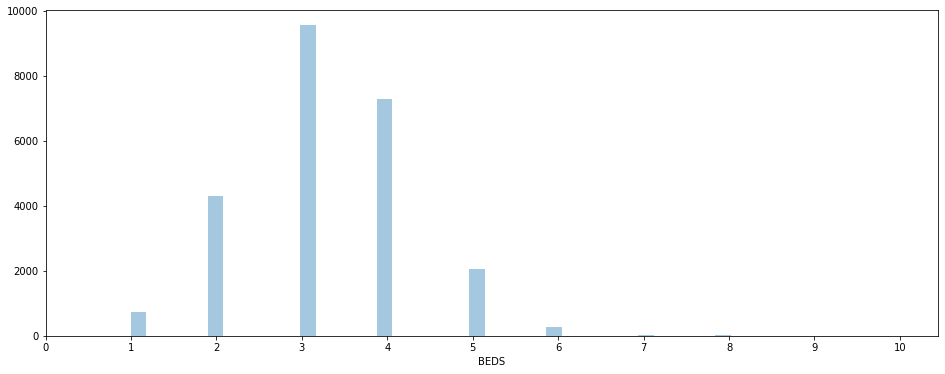

In [35]:
#Distribution of # of beds
plt.figure(figsize=(16, 6))
ax = sns.distplot(redfin['BEDS'], kde=False)
plt.xticks(np.arange(0, 11, step=1))
plt.show()

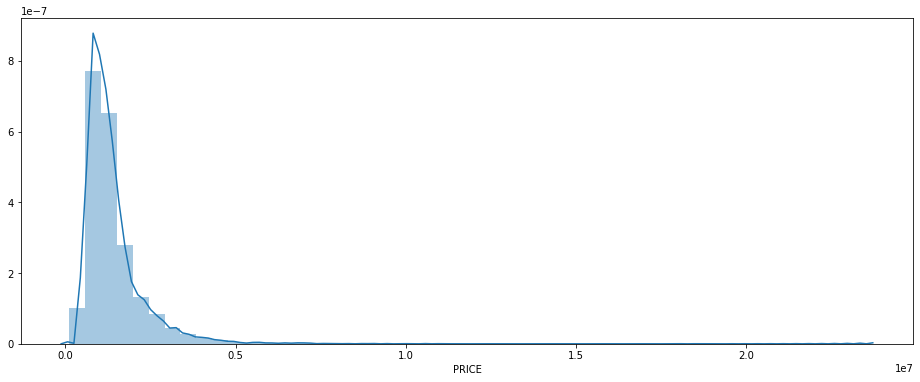

In [36]:
#Plot the distribution of price
#Long tail on the right
plt.figure(figsize=(16, 6))
ax = sns.distplot(redfin['PRICE'])
plt.show()

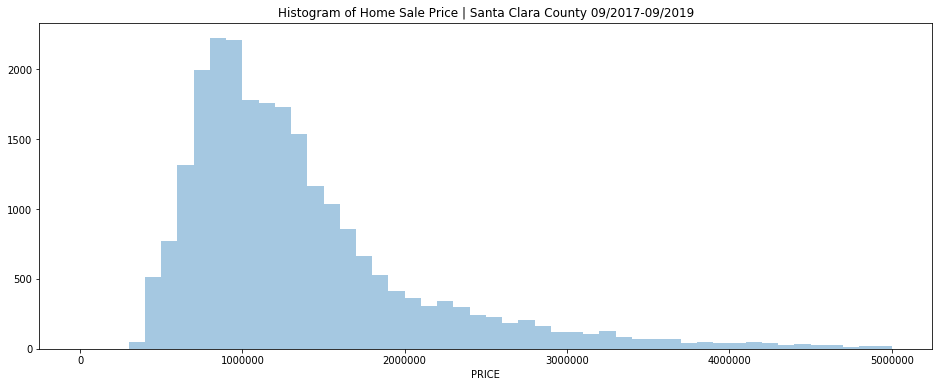

In [37]:
#Plot the distribution of price from 0 to 500K
plt.figure(figsize=(16, 6))
ax = sns.distplot(redfin['PRICE'], kde=False, hist_kws={"range": [0, 5000000]})
ax.set_title("Histogram of Home Sale Price | Santa Clara County 09/2017-09/2019")
plt.show()

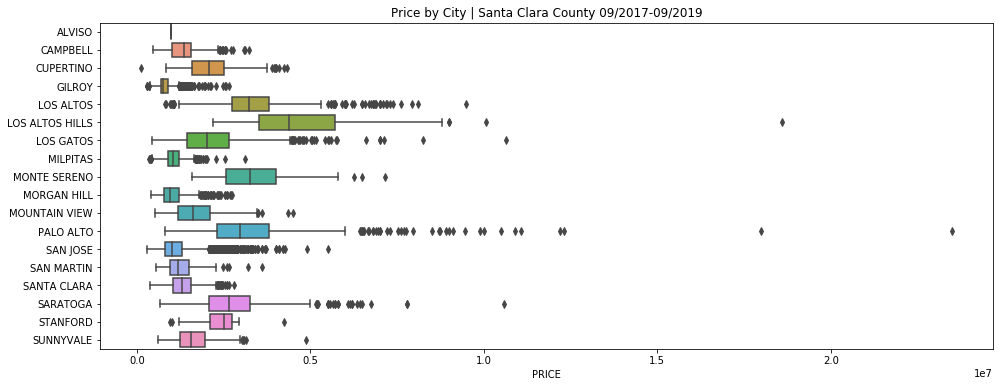

In [38]:
#Price by city
#Cities with >$5mm houses tend to be Los Altos, Los Altos Hills, Los Gatos, Palo Alto, and Saratoga
plt.figure(figsize=(16, 6))
redfin = redfin.sort_values(by=['CITY'])
ax = sns.boxplot(x="PRICE", y="CITY", orient="h", data=redfin)
#ax = sns.swarmplot(x="PRICE", y="CITY", orient="h", data=redfin, color="white")
ax.set_title("Price by City | Santa Clara County 09/2017-09/2019")
ax.set_ylabel('')

plt.show()

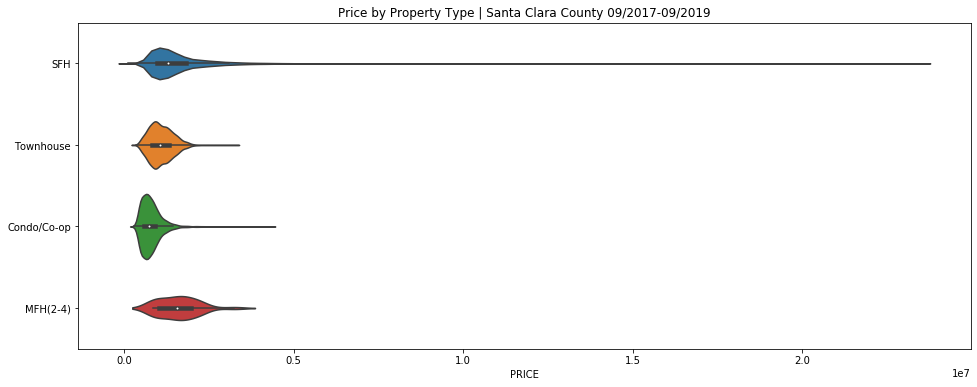

In [39]:
#Price by property type
#SFH has long tails, condo has lowest median price and MFH highest
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x="PRICE", y="PROPERTY TYPE", orient="h", data=redfin)
ax.set_title("Price by Property Type | Santa Clara County 09/2017-09/2019")
ax.set_ylabel('')

plt.show()

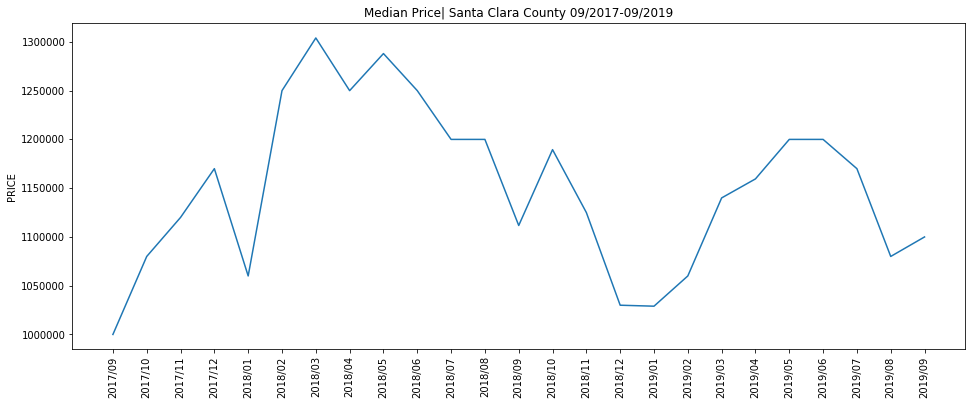

In [40]:
#House price trend in the last 2 years
#It rose to the highest in Q2/2018 and dropped like a rock; then came back in Q2/2019 and 
#dropped again in Q3. There's both cyclical trend and time series trend

#redfin
redfin = redfin.sort_values(by=['Date'])
redfin_median = redfin.groupby('Date').median()

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=redfin_median.index, y="PRICE", data=redfin_median)
plt.xticks(plt.xticks()[0], redfin_median.index, rotation=90)
ax.set_xlabel('')
ax.set_title("Median Price| Santa Clara County 09/2017-09/2019")
#plt.tight_layout()
plt.show()

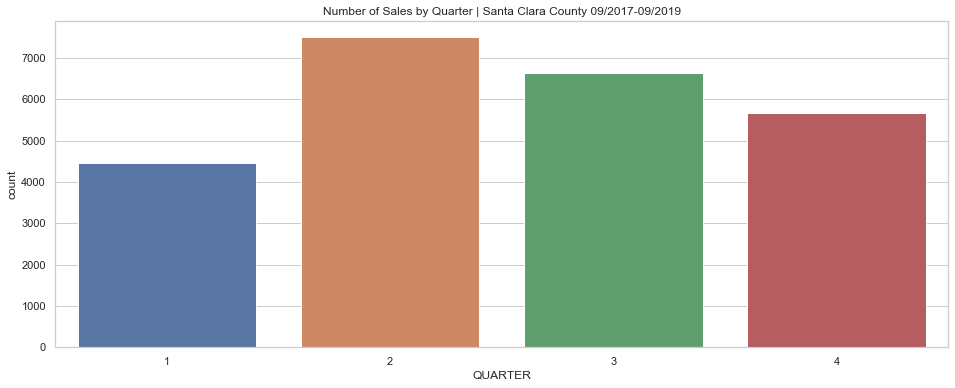

In [41]:
#Hypothesis: more sales in spring and summer
#Count the num of sales in each quarter. Surprisingly Q1 is less than Q4！

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="QUARTER", data=redfin)
ax.set_title("Number of Sales by Quarter | Santa Clara County 09/2017-09/2019")
plt.show()

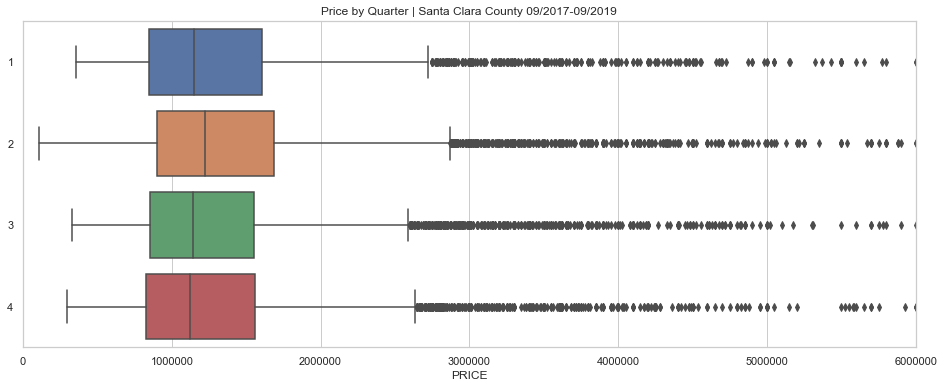

In [42]:
#Price by quarter
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="PRICE", y="QUARTER", orient="h", data=redfin)
ax.set_title("Price by Quarter | Santa Clara County 09/2017-09/2019")
ax.set_ylabel('')
plt.xlim(0, 6000000)

plt.show()

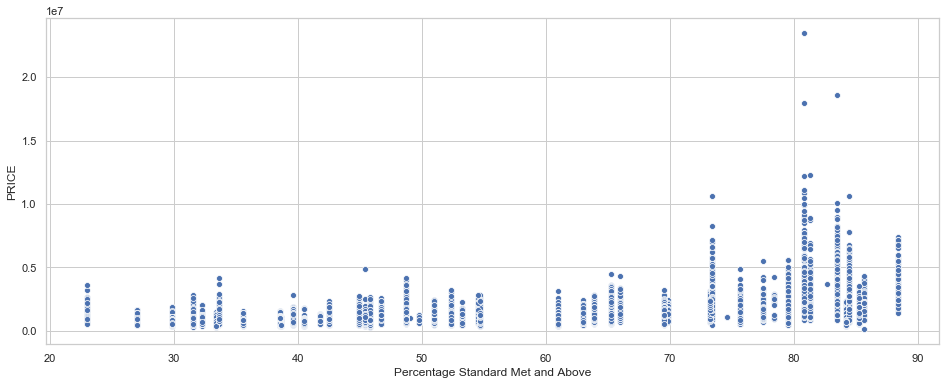

In [43]:
#Hypothese: Better schools, higher price
#The schools data are by zipcodes that's why the vertial dots
#Seems there's overall a positive relationship but not much trend when scores < 50 
#Alternative schools for below average publich school scores neighborhoods
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="Percentage Standard Met and Above", y="PRICE", data=redfin)
plt.show()

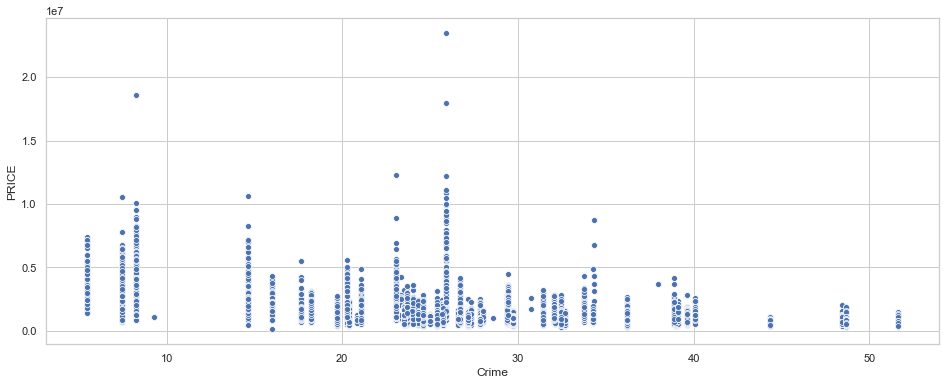

In [44]:
#Hypothese: Lower crimes, higher price
#The crime data are by zipcodes that's why the vertial dots
#Seems when crime is moderate to low (<50) no one cares, but negatively affact price when it
#gets higher (extremely high crime areas)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="Crime", y="PRICE", data=redfin)
plt.show()

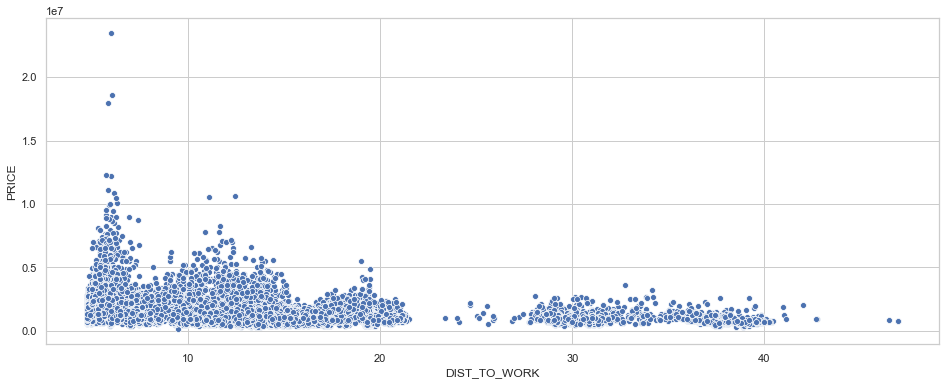

In [45]:
#Hypothese: closer to landmarks, higher price
#Generally it's true, although with some humps (other central location like SJ Downtown?)
#When miles is > 20 it doesn't matter much

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="DIST_TO_WORK", y="PRICE", data=redfin)
plt.show()

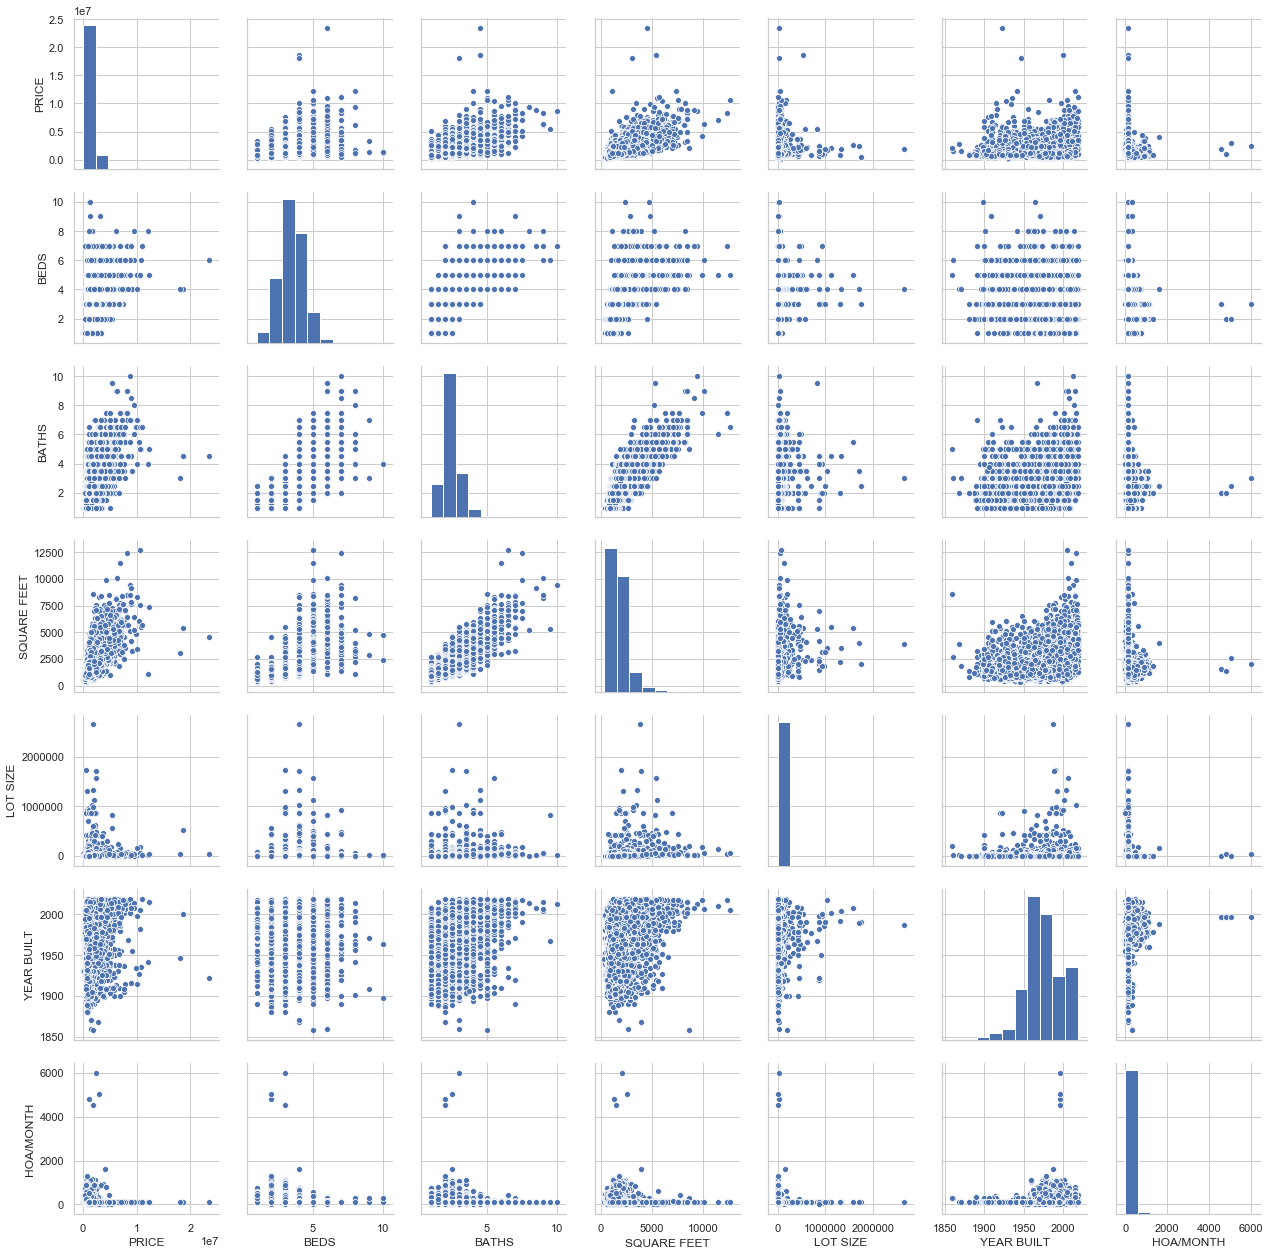

In [46]:
#pair plot essential features and price
#Square feet and year built seem to be positively related to price
#LOT SIZE exhibits negative relationship which is interesting
#When beds<5, it's positive relationship but after 5 it's negative probably because those
#houses are in surbubs really far away from work

redfin_essential = redfin[['PRICE', 'BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 
                           'YEAR BUILT', 'HOA/MONTH']]

g = sns.pairplot(redfin_essential)

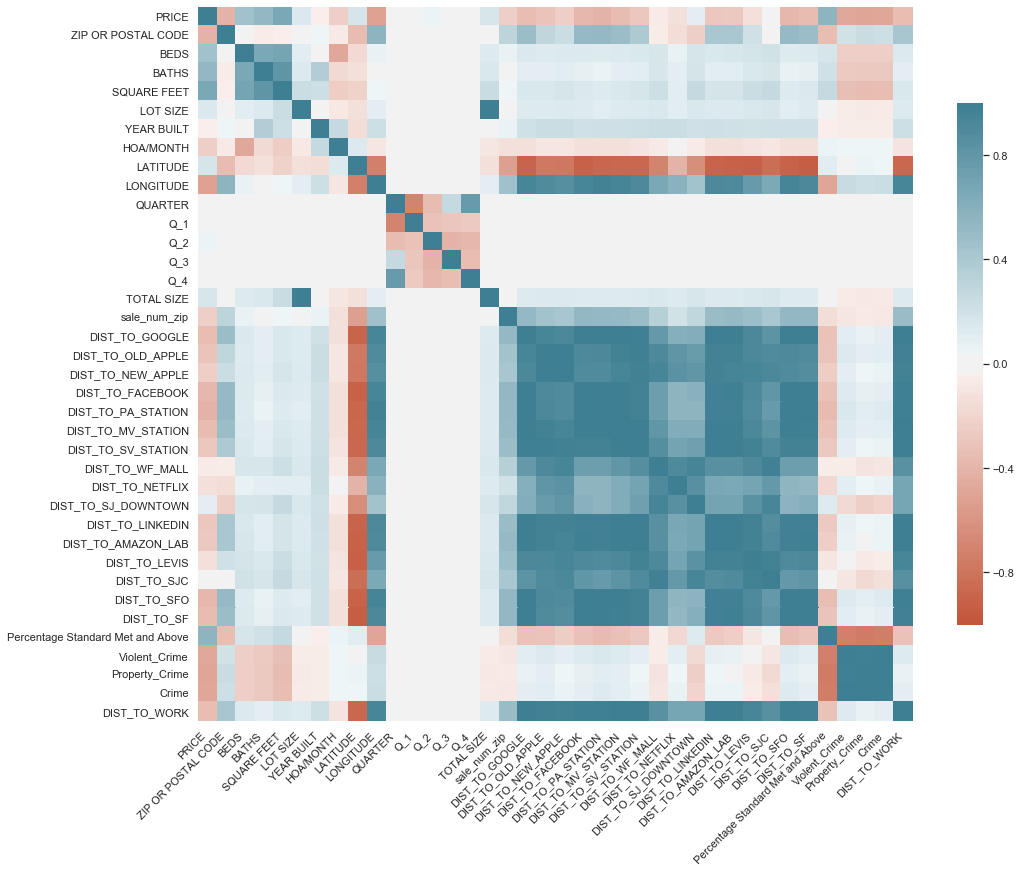

In [47]:
#Make a correlation heatmap

price = redfin['PRICE']
redfin.drop(labels=['PRICE'], axis=1,inplace = True)
redfin.insert(0, 'PRICE', price)

plt.figure(figsize=(16, 16))

corr = redfin.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, cbar=True,cbar_kws={"shrink": .6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

C:\Users\armcl\Anaconda3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


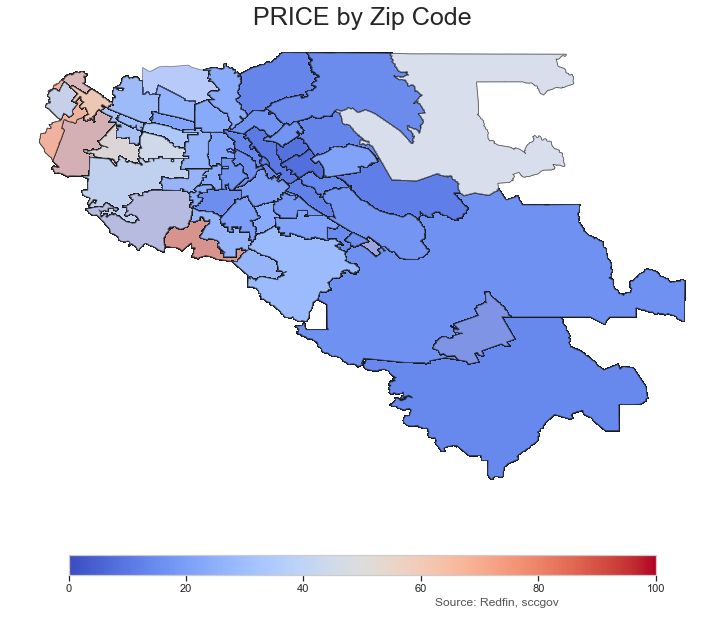

In [48]:
#Let's make a map!
import geopandas as gpd


#Santa Clara County shape file by zip code
map_df = gpd.read_file(data_path + "ba_map/zipcode_scc/Zip_Codes.shp")


redfin['ZIP OR POSTAL CODE'] = redfin['ZIP OR POSTAL CODE'].astype(str)
#redfin['ZIP OR POSTAL CODE'] = redfin['ZIP OR POSTAL CODE'].astype(str)

#Remove extremely high price
redfin_normal_price = redfin.loc[redfin['PRICE']<=5000000,:]
map_df = map_df.drop(columns=['LATITUDE','LONGITUDE'])

merged = map_df.set_index('ZCTA').join(redfin_normal_price.set_index('ZIP OR POSTAL CODE'))

variable = 'PRICE'

# set the range for the choropleth values
vmin, vmax = 0, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(variable + ' by Zip Code', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: Redfin, sccgov', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# add the colorbar to the figure
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)

# create map
merged.plot(column=variable, cmap='coolwarm', linewidth=0.8, ax=ax,
           alpha=0.5, edgecolor='k')


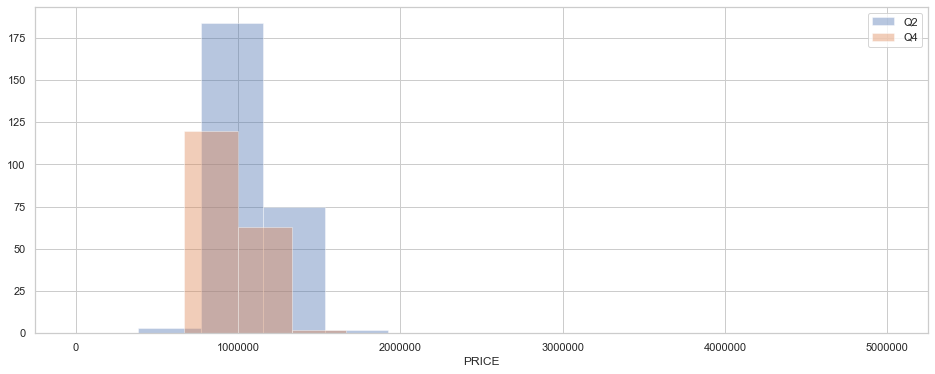

In [49]:
#Hypothesis: homes sold in Q2 are more expensive than Q4 controlling for the same size and zipcodes
#Why? People change jobs move around in summer, schools, people don't want to move when it's cold, 
#houses at the end of the year are the ones on market for a long time for different reasons thus discounts.
redfin_Q2 = redfin.loc[redfin['Q_2']==1,:] #7513
redfin_Q4 = redfin.loc[redfin['Q_4']==1,:] #5665

#Try something more rigorous.. Limit the property type, zip codes.. 
redfin_Q2 = redfin.loc[(redfin['ZIP OR POSTAL CODE']=='95123') & (redfin['PROPERTY TYPE'] == 'SFH') & (redfin['Q_2']==1),:]
redfin_Q4 = redfin.loc[(redfin['ZIP OR POSTAL CODE']=='95123') & (redfin['PROPERTY TYPE'] == 'SFH') & (redfin['Q_4']==1),:]


plt.figure(figsize=(16, 6))
ax = sns.distplot(redfin_Q2['PRICE'], kde=False, label="Q2", hist_kws={"range": [0, 5000000]})
ax = sns.distplot(redfin_Q4['PRICE'], kde=False, label="Q4", hist_kws={"range": [0, 5000000]})
plt.legend()
plt.show()

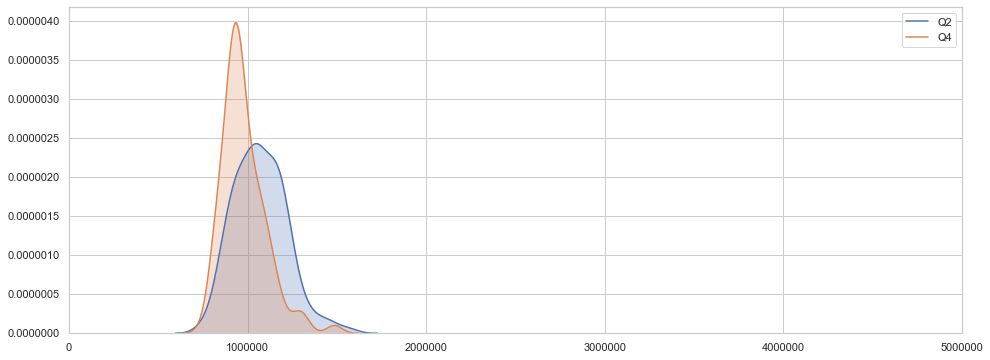

In [50]:
plt.figure(figsize=(16, 6))
ax = sns.kdeplot(redfin_Q2['PRICE'], shade = True, label="Q2")
ax = sns.kdeplot(redfin_Q4['PRICE'], shade = True, label="Q4")
plt.xlim(0, 5000000)

plt.legend()
plt.show()

In [51]:
#Q4 price is lower in terms of mean and median but more spreaded out
#Q4 median price is around $100K lower than Q1 sounds like there's indeed a deal

redfin_Q2['PRICE'].describe()

count    2.640000e+02
mean     1.070864e+06
std      1.477281e+05
min      7.500000e+05
25%      9.600000e+05
50%      1.060000e+06
75%      1.171250e+06
max      1.575000e+06
Name: PRICE, dtype: float64

In [52]:
redfin_Q4['PRICE'].describe()

count    1.850000e+02
mean     9.799666e+05
std      1.229149e+05
min      7.500000e+05
25%      9.010000e+05
50%      9.500000e+05
75%      1.050000e+06
max      1.498000e+06
Name: PRICE, dtype: float64

In [53]:
#Run a T Test
#Null: the means are the same for Q2 and Q4
#Null is rejected
#This is assuming holding all other variables constant
#A multivariate regression will be more rigorous in controlling other features

from scipy import stats
#np.random.seed(88)

Q2_PRICE = redfin_Q2['PRICE']
Q4_PRICE = redfin_Q4['PRICE']

#t, p = stats.ttest_ind(Q2_PRICE,Q4_PRICE)
t, p = stats.ttest_ind(Q2_PRICE, Q4_PRICE, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = 7.090716136645226
p = 5.448952876923297e-12


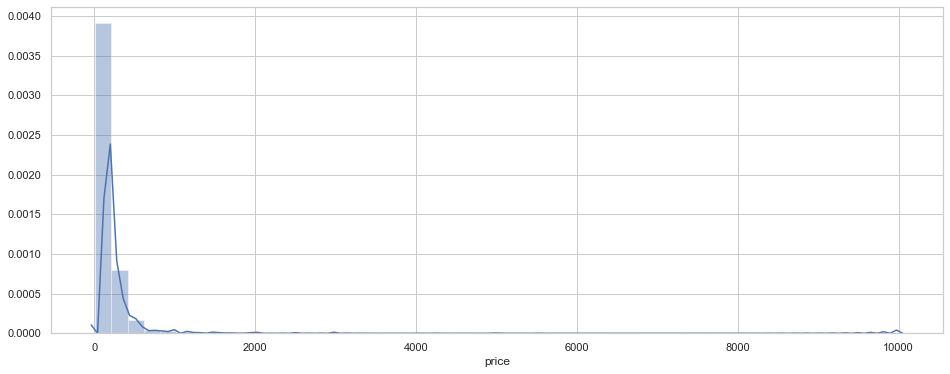

In [54]:
#Airbnb data storytelling
#Distribution of listing price
plt.figure(figsize=(16, 6))
ax = sns.distplot(airbnb['price'])
plt.show()

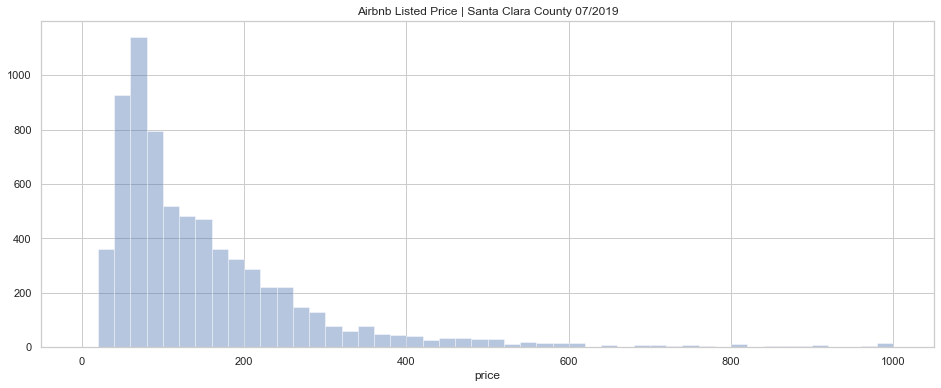

In [55]:
#Distribution of listing price limited to <1000
#The majority prices are between 0 and 200/day
plt.figure(figsize=(16, 6))
ax = sns.distplot(airbnb['price'], kde=False, hist_kws={"range": [0, 1000]})
ax.set_title("Airbnb Listed Price | Santa Clara County 07/2019")

plt.show()

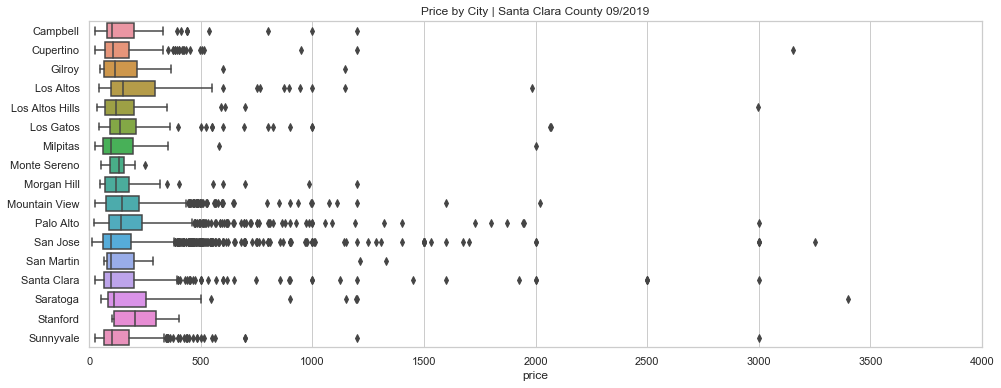

In [56]:
#Price by city
#Limited to <4000 to zoom in
#Compared to sale price, the "premium" neighborhoods do not necessarily have higher listing price on airbnb
#Poorer popoulation in the higher end neighborhoods might explain the average list price
plt.figure(figsize=(16, 6))
plt.xlim(0, 4000)
airbnb = airbnb.sort_values(by=['city'])
ax = sns.boxplot(x="price", y="city", orient="h", data=airbnb)
#ax = sns.swarmplot(x="PRICE", y="CITY", orient="h", data=redfin, color="white")
ax.set_title("Price by City | Santa Clara County 09/2019")
ax.set_ylabel('')

plt.show()

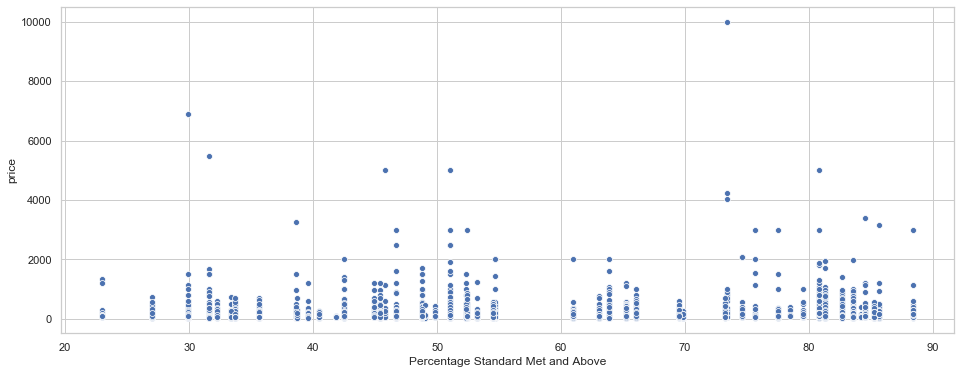

In [57]:
#Hypothese: Schools don't affect airbnb price much
#And yes, price is relatively flat across school scores

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="Percentage Standard Met and Above", y="price", data=airbnb)
plt.show()

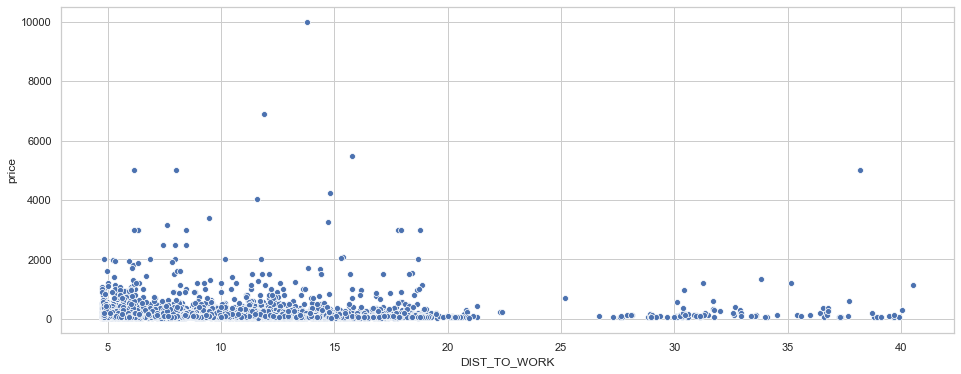

In [58]:
#Hypothese: closer to companies, higher price
#Generally it seems true
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="DIST_TO_WORK", y="price", data=airbnb)
plt.show()

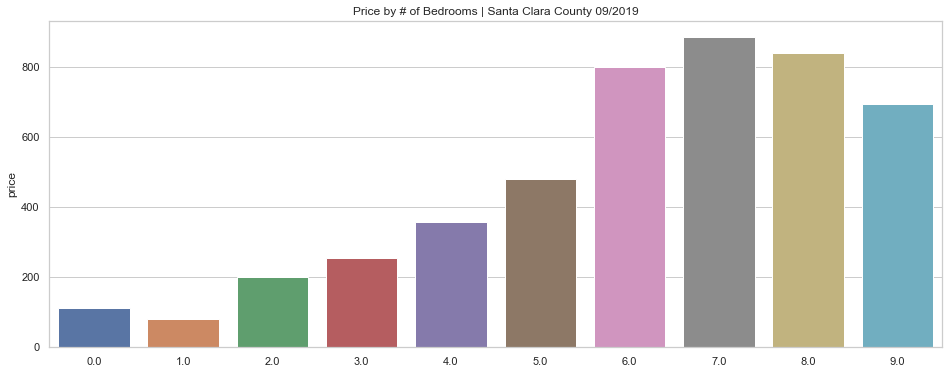

In [59]:
#Hypothesis: more beds, more expensive
#It's generally true although flat after 6
airbnb_beds = airbnb.loc[airbnb['bedrooms']<10,:]
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="bedrooms", y="price", data=airbnb_beds, estimator=median, ci=None)
ax.set_title("Price by # of Bedrooms | Santa Clara County 09/2019")
ax.set_xlabel('')
plt.show()

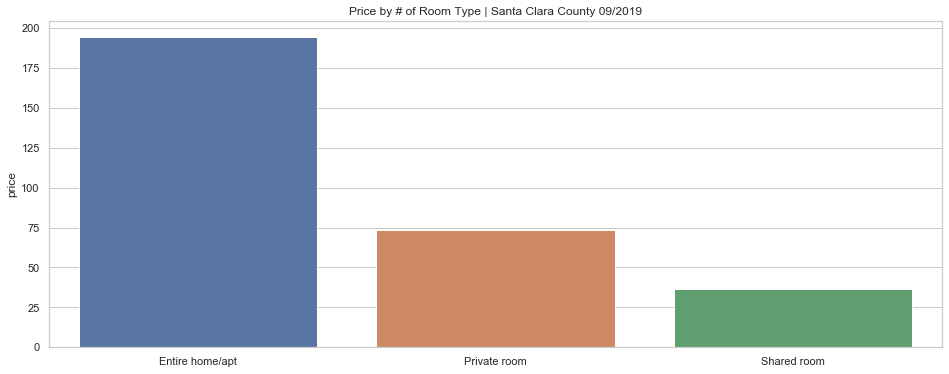

In [60]:
#Hypothesis: privacy costs more
#This is pretty clear
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="room_type", y="price", data=airbnb, estimator=median, ci=None)
ax.set_title("Price by # of Room Type | Santa Clara County 09/2019")
ax.set_xlabel('')
plt.show()

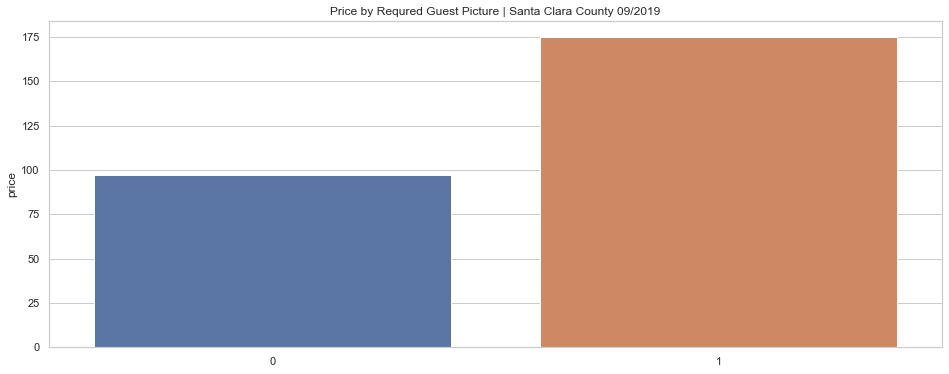

In [61]:
#Hypothesis: family/kids friendly costs more
#This seems true!
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="family/kid_friendly", y="price", data=airbnb, estimator=median, ci=None)
ax.set_title("Price by Requred Guest Picture | Santa Clara County 09/2019")
ax.set_xlabel('')
plt.show()

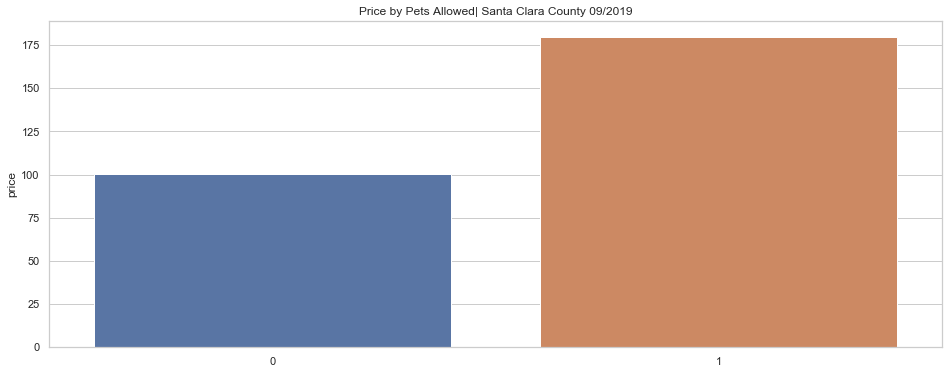

In [62]:
#Hypothesis: It's not cheap to travel with pets!
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="pets_allowed", y="price", data=airbnb, estimator=median, ci=None)
ax.set_title("Price by Pets Allowed| Santa Clara County 09/2019")
ax.set_xlabel('')
plt.show()

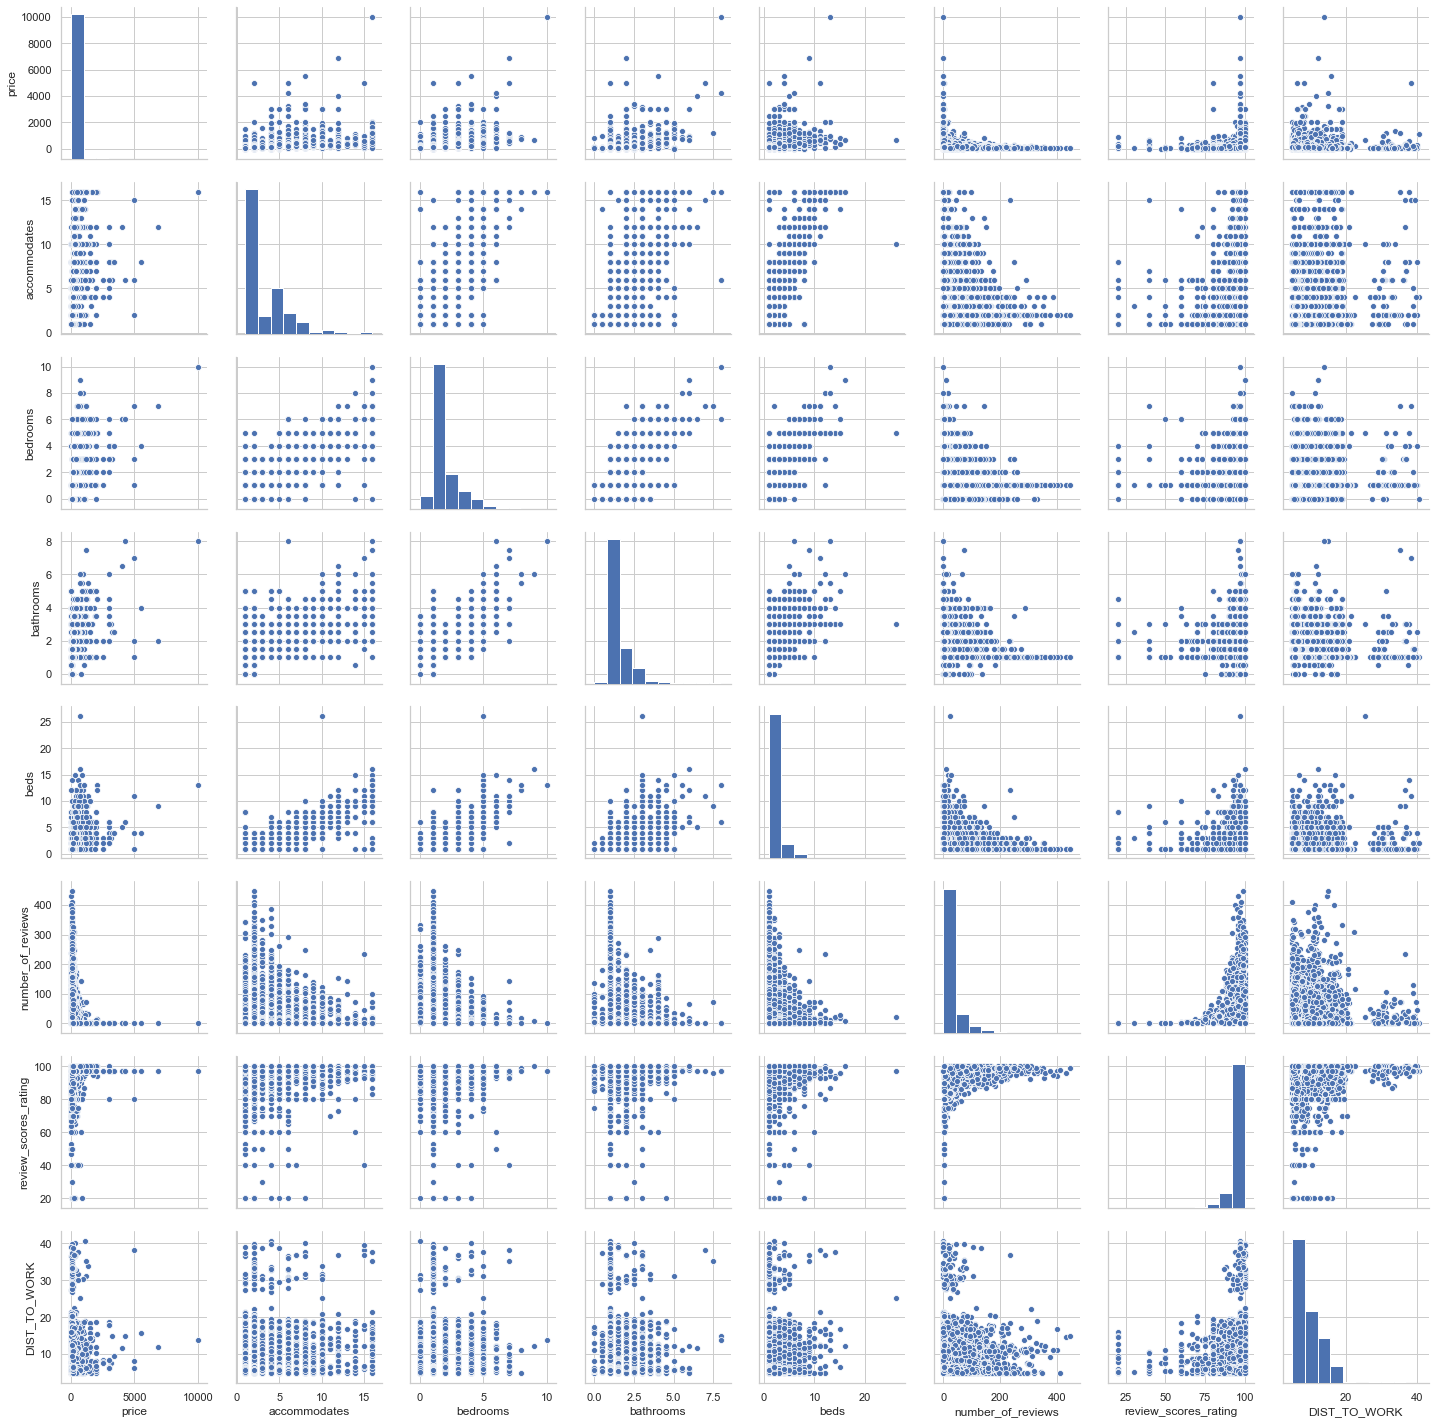

In [63]:
#pair plot essential features and price
#Accomodations, bedrooms, beds, review scores, and distance all seem to be positively related to price

airbnb_essential = airbnb[['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
                           'number_of_reviews', 'review_scores_rating','DIST_TO_WORK']]

g = sns.pairplot(airbnb_essential)

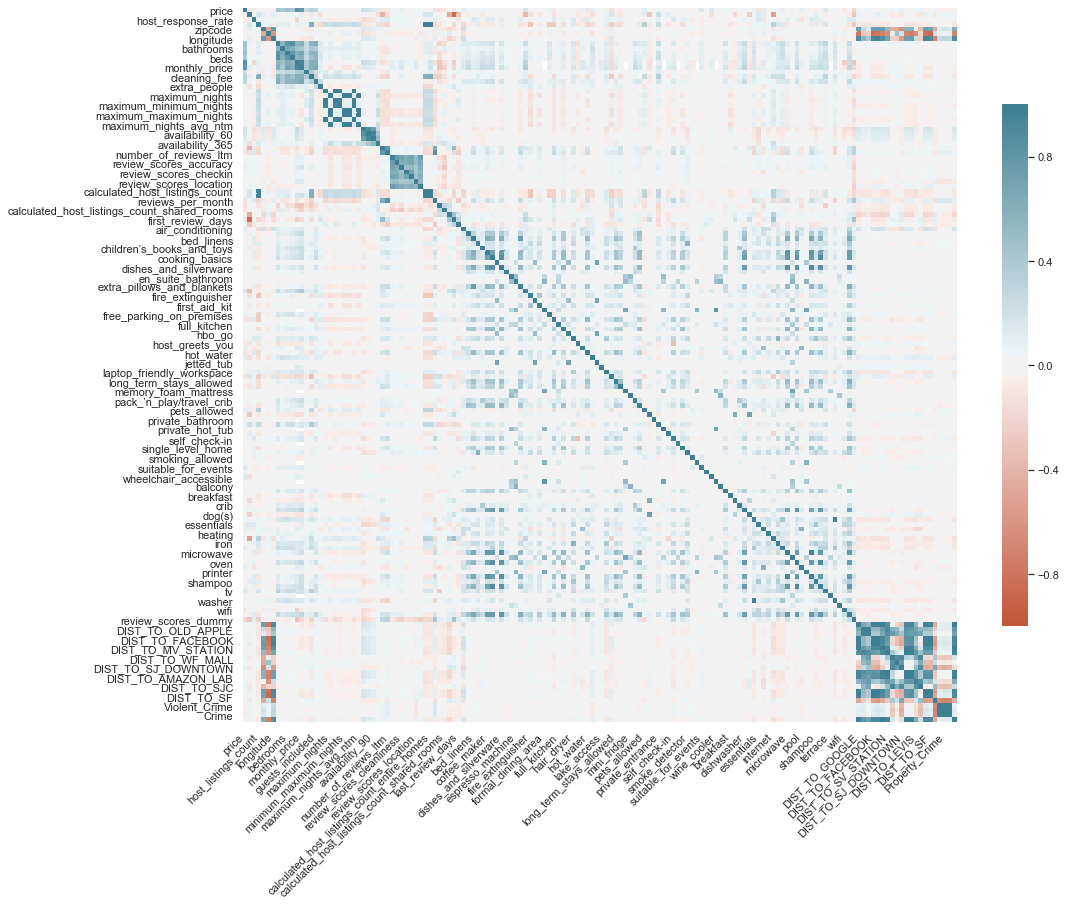

In [64]:
#Make a correlation heatmap
price = airbnb['price']
airbnb.drop(labels=['price'], axis=1,inplace = True)
airbnb.insert(0, 'price', price)

plt.figure(figsize=(16, 16))

corr = airbnb.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, cbar=True,cbar_kws={"shrink": .6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [65]:
###################
#Machine Learning#

redfin = pd.read_csv(data_path + "redfin_clean_scc.csv")
#Extra cleaning
redfin = redfin.rename(columns={"PROPERTY TYPE": "PROPERTY_TYPE", "ZIP OR POSTAL CODE": "ZIPCODE",
                      "SQUARE FEET": "SQUARE_FEET", "LOT SIZE": "LOT_SIZE", 
                      "YEAR BUILT": "YEAR", "TOTAL SIZE":"TOTAL_SIZE", 
                      "Percentage Standard Met and Above":"SCHOOL"})

redfin = redfin.drop(columns = ['SOLD DATE', 'CITY', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
                               'QUARTER','Date'])

redfin = pd.get_dummies(redfin, columns=['PROPERTY_TYPE'])


In [66]:
#Remove outliers with high purchase price which are generally not for investments
redfin = redfin.loc[redfin['PRICE'] <= 3000000, :]

#Standardize the data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

target_column = ['PRICE'] 
predictors = list(redfin.columns)[1:]
redfin[predictors] = scaler.fit_transform(redfin[predictors])
#redfin[target_column] = scaler.fit_transform(redfin[target_column])


In [67]:
#Creating the Training and Test Datasets
from sklearn.model_selection import train_test_split

X = redfin[predictors]
y = redfin[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

In [68]:
#Simple Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)

#Return the R^2
print("LR training score:",lr_train_score)
print("LR test score:",lr_test_score)

LR training score: 0.8394526937472735
LR test score: 0.8420192034141999


In [69]:
#Use Lasso to prevent overfitting and reduce features
from sklearn.linear_model import LassoCV

LassoReg = LassoCV()
LassoReg.fit(X_train, y_train)

coef = pd.Series(LassoReg.coef_, index = predictors)

print("Best alpha using built-in LassoCV: %f" % LassoReg.alpha_)
print("Best training score using built-in LassoCV: %f" % LassoReg.score(X_train, y_train))
print("Best test score using built-in LassoCV: %f" % LassoReg.score(X_test, y_test))


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 835851274398.0, tolerance: 380573279955.9822
  tol, rng, random, positive)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1104705643810.25, tolerance: 380573279955.9822
  tol, rng, random, positive)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

Best alpha using built-in LassoCV: 308.084027
Best training score using built-in LassoCV: 0.833720
Best test score using built-in LassoCV: 0.833903


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137536947159225.12, tolerance: 476397313607.35834
  positive)


In [70]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 29 variables and eliminated the other 8 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

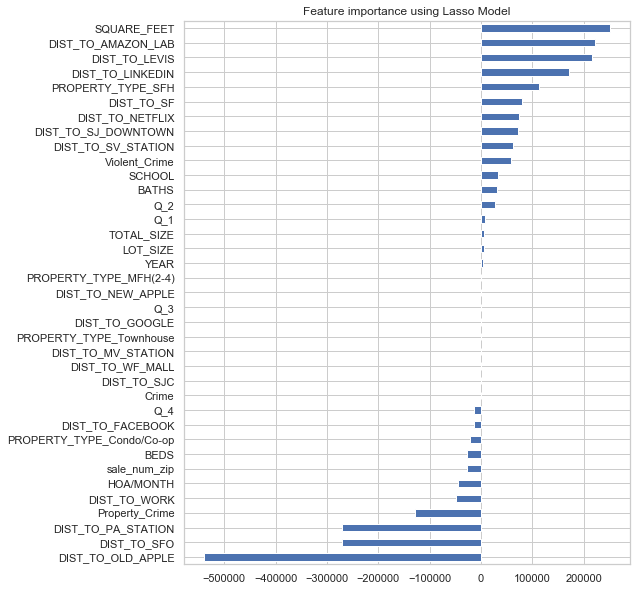

In [71]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Text(0.5, 1.0, 'Relationship between Original and Predicted Price')

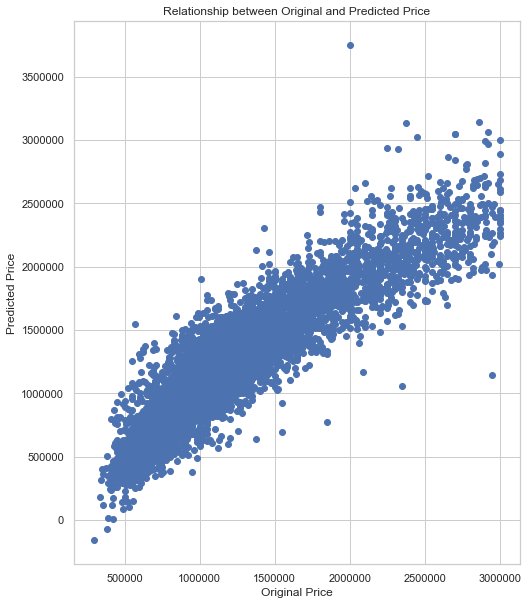

In [72]:
original = y_test.PRICE
fitted = LassoReg.predict(X_test)

#Fitted vs. Original

#Homes with price > $5mm show big errors
plt.scatter(original, fitted)
plt.xlabel("Original Price")
plt.ylabel("Predicted Price")
plt.title("Relationship between Original and Predicted Price")

Text(0.5, 1.0, 'Relationship between Residuals and Fitted Values')

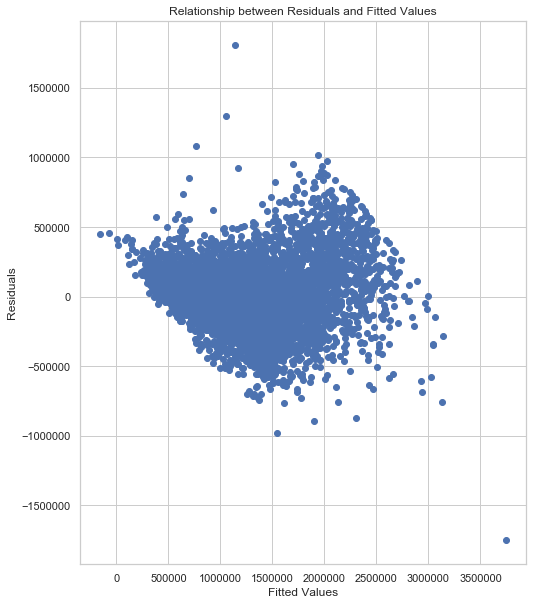

In [73]:
#Residuals vs. Fitted

residuals = y_test['PRICE'].to_numpy() - fitted

plt.scatter(fitted, residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Relationship between Residuals and Fitted Values")

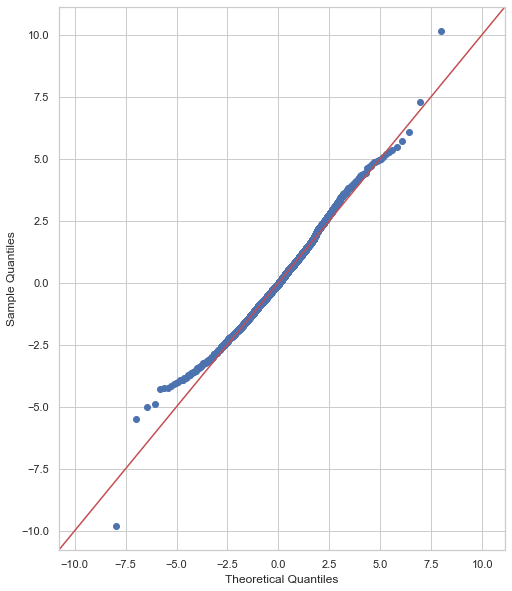

In [76]:
#QQ Plot
import scipy.stats as stats
import statsmodels.api as sm

fig = sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.show()

In [77]:
airbnb = pd.read_csv(data_path + "airbnb_clean_scc.csv")

#Remove outliers prices
airbnb = airbnb.loc[airbnb['price'] <= 500, :]

#Remove high vacany listings (unreasonable high prices/newly listed)
#My goal is to find the "equilibrium" rental prices
#which ideally is non-available dates that are actually booked (not blocked)

airbnb = airbnb.loc[airbnb['availability_30'] <=7, :]

#Remove potentially new listings
airbnb = airbnb.loc[airbnb['number_of_reviews_ltm'] >=5, :]

In [78]:
#Target variable
airbnb['monthly_rent'] = airbnb['price'] * (30-airbnb['availability_30'])

In [79]:
#Extra cleaning

airbnb = airbnb.drop(columns = ['id','state','city','zipcode',
                               'weekly_price','monthly_price','host_listings_count',
                               'DIST_TO_SF','DIST_TO_FACEBOOK','DIST_TO_SFO',
                               'price','availability_30'])

airbnb = pd.get_dummies(airbnb, columns=[
                                         'host_response_time','host_is_superhost',
                                        'host_has_profile_pic','host_identity_verified',
                                        'property_type','room_type','bed_type',
                                        'instant_bookable','cancellation_policy',
                                        'require_guest_profile_picture',
                                        'require_guest_phone_verification'
                                        ])


airbnb = airbnb.rename(columns={ 
"Percentage Standard Met and Above":"SCHOOL",
"room_type_Entire home/apt":"Rent_Entire_Home",
"bedrooms":"BEDS", 'bathrooms':"BATHS",'latitude':'LATITUDE','longitude':'LONGITUDE',
'property_type_Condominium':'PROPERTY_TYPE_Condo/Co-op',
'property_type_House':'PROPERTY_TYPE_SFH',
'property_type_Townhouse':'PROPERTY_TYPE_Townhouse'})


In [80]:
selected_cols_airbnb = ['monthly_rent','BEDS','BATHS','LATITUDE','LONGITUDE',
                 'DIST_TO_GOOGLE','DIST_TO_OLD_APPLE','DIST_TO_NEW_APPLE',
                 'DIST_TO_PA_STATION','DIST_TO_MV_STATION','DIST_TO_SV_STATION','DIST_TO_WF_MALL',
                 'DIST_TO_NETFLIX','DIST_TO_SJ_DOWNTOWN','DIST_TO_LINKEDIN','DIST_TO_AMAZON_LAB',
                 'DIST_TO_LEVIS','DIST_TO_SJC','SCHOOL','Violent_Crime','Property_Crime',
                 'Crime','DIST_TO_WORK','PROPERTY_TYPE_Condo/Co-op','PROPERTY_TYPE_SFH',
                 'PROPERTY_TYPE_Townhouse','Rent_Entire_Home']

airbnb = airbnb.loc[:,selected_cols_airbnb]

In [81]:
target_column_airbnb = ['monthly_rent'] 

predictors_airbnb = list(airbnb.drop('monthly_rent', axis=1).columns)

airbnb[predictors_airbnb] = scaler.fit_transform(airbnb[predictors_airbnb])

In [82]:
#Creating the Training and Test Datasets
from sklearn.model_selection import train_test_split

X = airbnb[predictors_airbnb]
y = airbnb[target_column_airbnb]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(1655, 26)
(710, 26)


In [83]:
#Use Lasso to prevent overfitting and reduce features

LassoReg = LassoCV()
LassoReg.fit(X_train, y_train)

coef = pd.Series(LassoReg.coef_, index = predictors_airbnb)

print("Best alpha using built-in LassoCV: %f" % LassoReg.alpha_)
print("Best training score using built-in LassoCV: %f" % LassoReg.score(X_train, y_train))
print("Best test score using built-in LassoCV: %f" % LassoReg.score(X_test, y_test))

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 1.919678
Best training score using built-in LassoCV: 0.720763
Best test score using built-in LassoCV: 0.723300
Lasso picked 18 variables and eliminated the other 8 variables


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679291.299148798, tolerance: 752061.2085632565
  tol, rng, random, positive)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

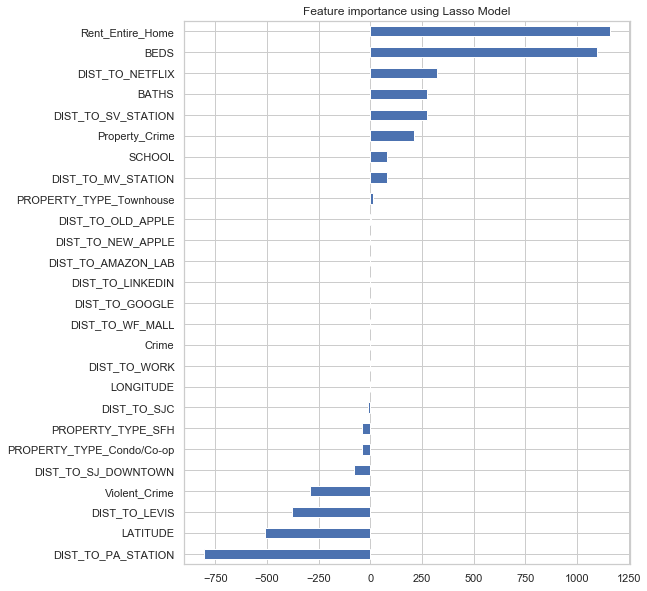

In [84]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Text(0.5, 1.0, 'Relationship between Original and Predicted Price')

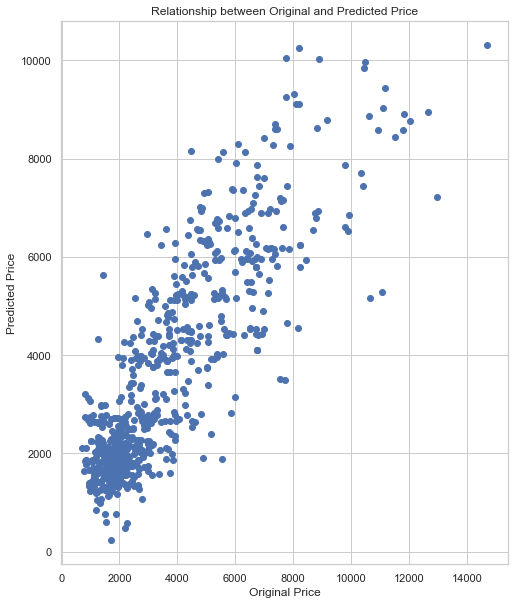

In [85]:
original = y_test.monthly_rent
fitted = LassoReg.predict(X_test)

#Fitted vs. Original
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)

#Homes with price > $5mm show big errors
plt.scatter(original, fitted)
plt.xlabel("Original Price")
plt.ylabel("Predicted Price")
plt.title("Relationship between Original and Predicted Price")

Text(0.5, 1.0, 'Relationship between Residuals and Fitted Values')

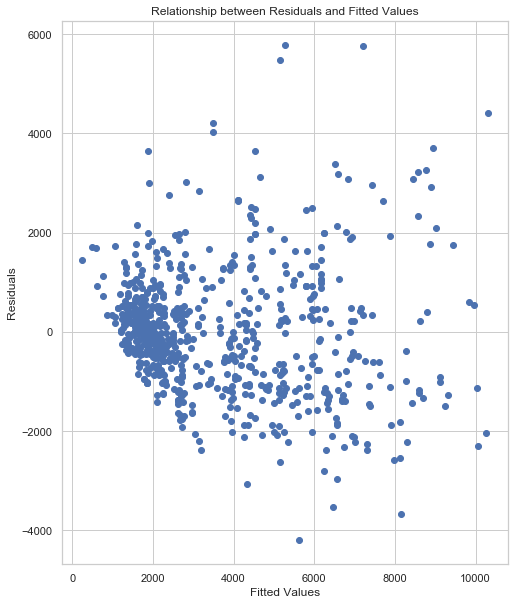

In [86]:
#Residuals vs. Fitted

residuals = y_test['monthly_rent'].to_numpy() - fitted

plt.scatter(fitted, residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Relationship between Residuals and Fitted Values")

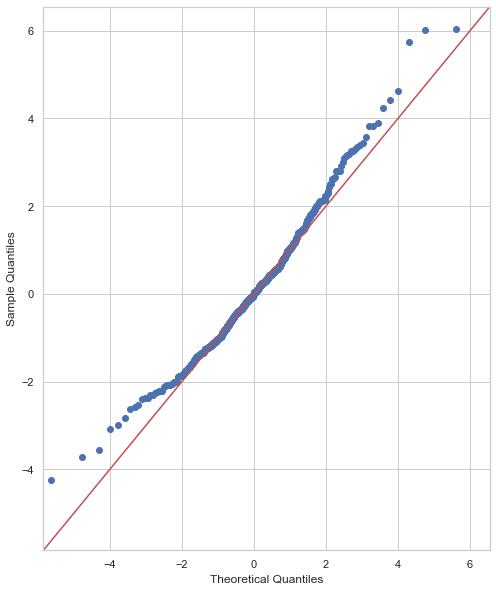

In [87]:
#QQ Plot
import scipy.stats as stats

fig = sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.show()

In [88]:
#Random Forest
redfin = pd.read_csv(data_path + "redfin_clean_scc.csv")

#Extra cleaning
redfin = redfin.rename(columns={"PROPERTY TYPE": "PROPERTY_TYPE", "ZIP OR POSTAL CODE": "ZIPCODE",
                      "SQUARE FEET": "SQUARE_FEET", "LOT SIZE": "LOT_SIZE", 
                      "YEAR BUILT": "YEAR", "TOTAL SIZE":"TOTAL_SIZE", 
                      "Percentage Standard Met and Above":"SCHOOL"})

#redfin = redfin.loc[redfin['ZIPCODE'] == 95051, :]

redfin = redfin.drop(columns = ['SOLD DATE', 
                               'QUARTER','Date','DIST_TO_FACEBOOK','DIST_TO_SFO',
                               'DIST_TO_SF','TOTAL_SIZE'])

redfin['zipcode'] = redfin['ZIPCODE']
redfin['city'] = redfin['CITY']
redfin = pd.get_dummies(redfin, columns=['PROPERTY_TYPE','CITY','ZIPCODE'])

In [89]:
redfin = redfin.loc[redfin['PRICE'] <= 3000000, :]
target_column_redfin = ['PRICE'] 
predictors_redfin = list(redfin.drop(columns=['PRICE','zipcode','city']).columns)

In [90]:
#Creating the Training and Test Datasets
from sklearn.model_selection import train_test_split

X_redfin = redfin[predictors_redfin]
y_redfin = redfin[target_column_redfin]

X_train_redfin, X_test_redfin, y_train_redfin, y_test_redfin = train_test_split(X_redfin, y_redfin, test_size=0.30,random_state=40)

print(X_train_redfin.shape); print(X_test_redfin.shape)

(16141, 110)
(6918, 110)


In [91]:
from sklearn.ensemble import RandomForestRegressor

#Create a Gaussian Classifier
rfr_redfin=RandomForestRegressor(n_estimators=100, random_state = 42, 
                                max_depth = 20) #number of trees in the forest

#Baseline model
#Train the model using the training sets y_pred=rfr_redfin.predict(X_test)
rfr_redfin.fit(X_train_redfin,y_train_redfin)

print("Training Score:",rfr_redfin.score(X_train_redfin, y_train_redfin))

print("Test Score:",rfr_redfin.score(X_test_redfin, y_test_redfin))

y_true_redfin = y_test_redfin.PRICE
y_pred_redfin =rfr_redfin.predict(X_test_redfin)

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:",round(sqrt(mean_squared_error(y_true_redfin, y_pred_redfin)), 2))

from sklearn.metrics import median_absolute_error
print("Median Absolute Error: " + str(round(median_absolute_error(y_true_redfin, y_pred_redfin), 2)))

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Score: 0.9887296903189263
Test Score: 0.925372017065906
RMSE: 148256.61
Median Absolute Error: 69979.68


In [92]:
#Parameters used in Random Forest Regressor
from pprint import pprint
pprint(rfr_redfin.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


No handles with labels found to put in legend.


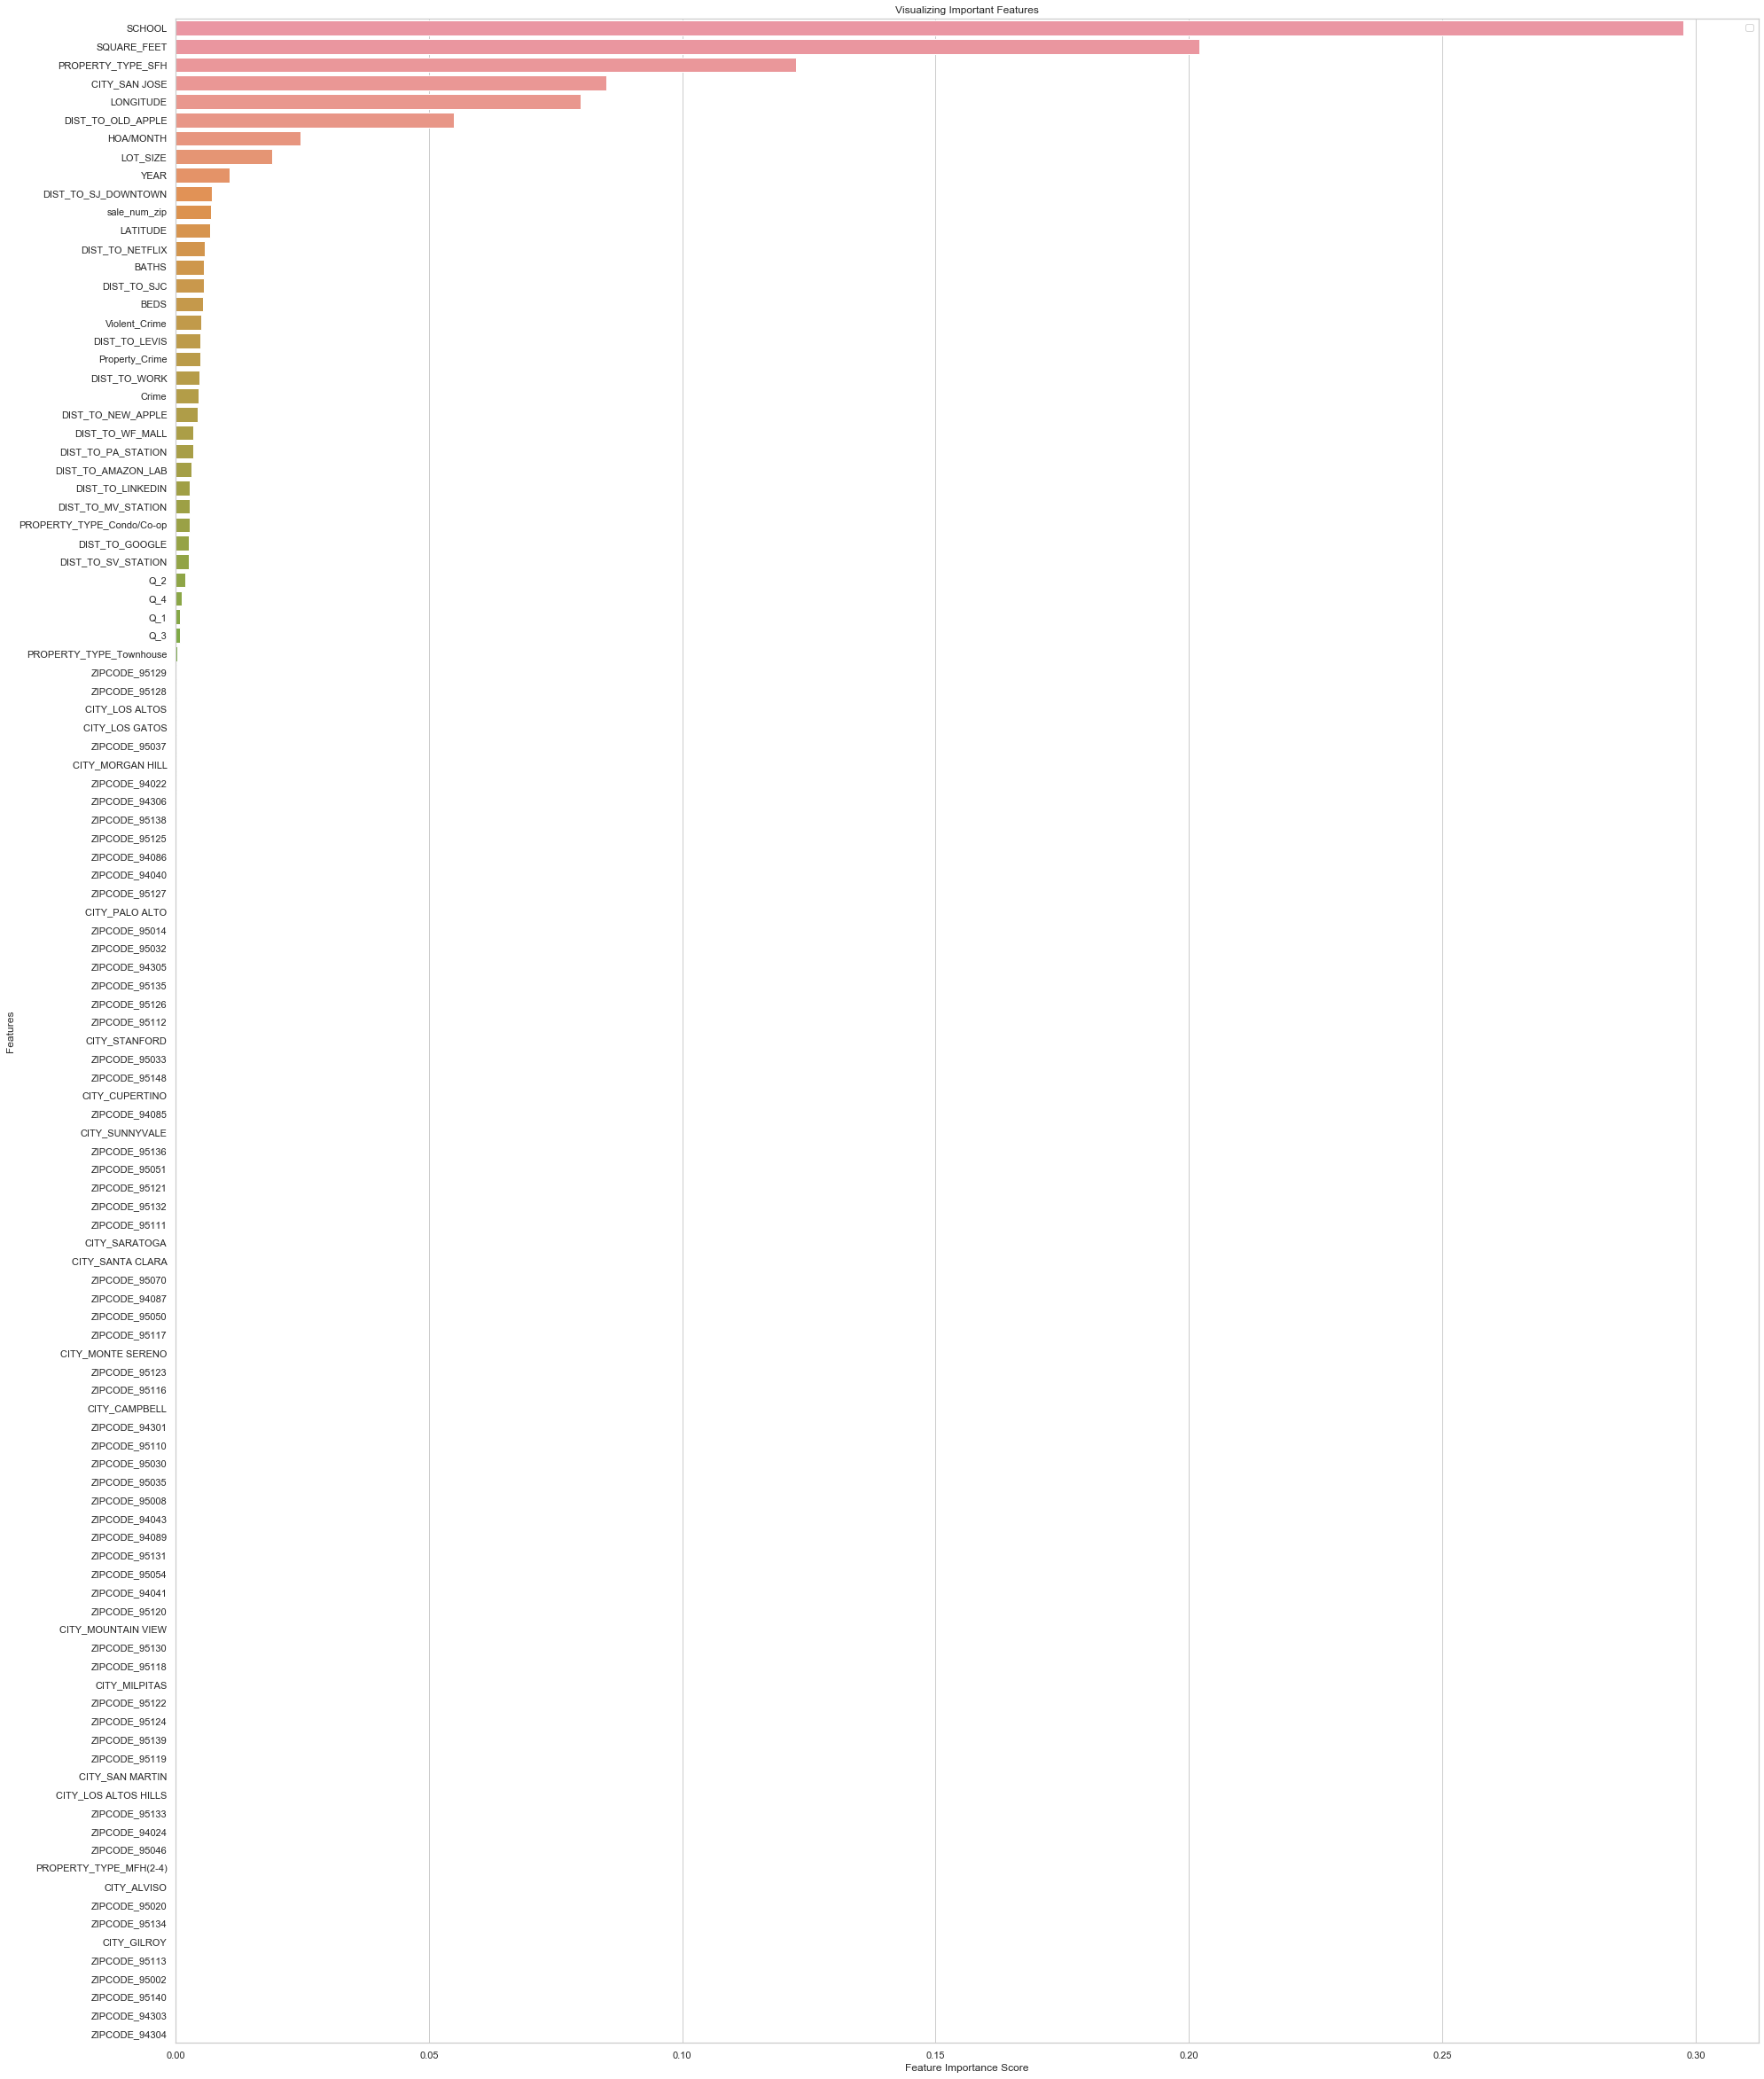

In [93]:
feature_imp_redfin = pd.Series(rfr_redfin.feature_importances_,index=predictors_redfin).sort_values(ascending=False)
plt.figure(figsize=(32, 42))
sns.barplot(x=feature_imp_redfin, y=feature_imp_redfin.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Relationship between Original and Predicted Price')

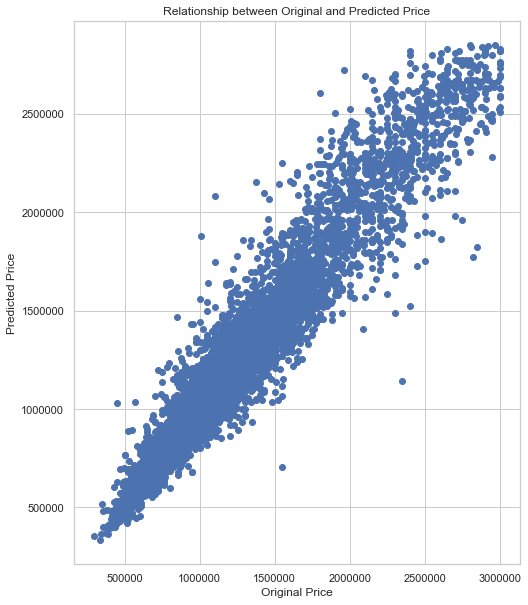

In [94]:
#Fitted vs. Original

#Homes with price > $5mm show big errors
plt.scatter(y_true_redfin, y_pred_redfin)
plt.xlabel("Original Price")
plt.ylabel("Predicted Price")
plt.title("Relationship between Original and Predicted Price")

Text(0.5, 1.0, 'Relationship between Residuals and Fitted Values')

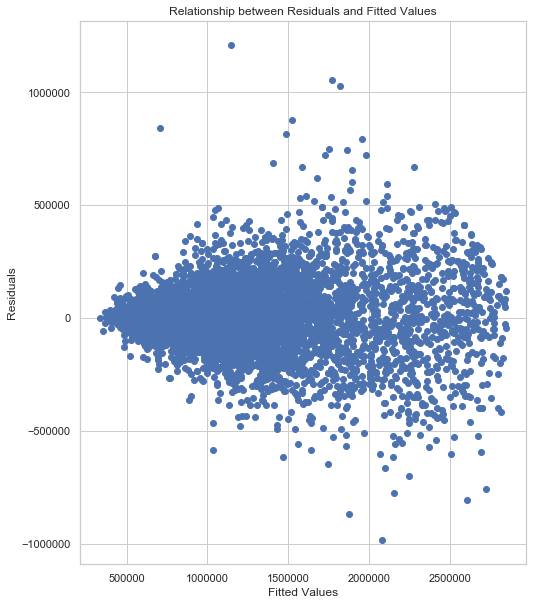

In [95]:
#Residuals vs. Fitted

residuals_redfin = y_test_redfin['PRICE'].to_numpy() - y_pred_redfin

plt.scatter(y_pred_redfin, residuals_redfin)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Relationship between Residuals and Fitted Values")

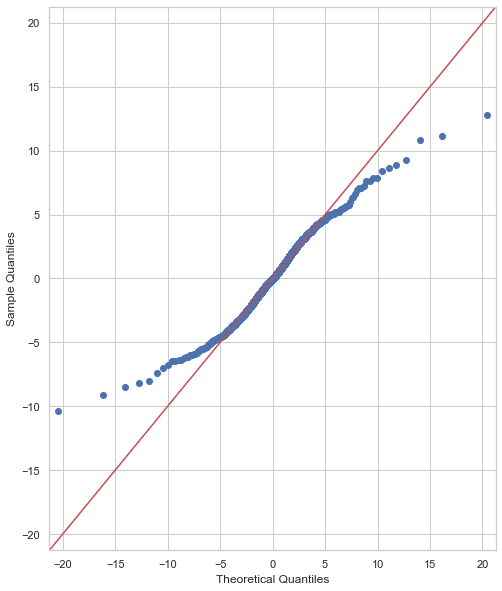

In [96]:
#QQ Plot
import scipy.stats as stats

fig = sm.qqplot(residuals_redfin, stats.t, fit=True, line='45')
plt.show()

In [97]:
airbnb = pd.read_csv(data_path + "airbnb_clean_scc.csv")

#Remove outliers prices
airbnb = airbnb.loc[airbnb['price'] <= 500, :]

#Remove high vacany listings (unreasonable high prices/newly listed)
#My goal is to find the "equilibrium" rental prices
#which ideally is non-available dates that are actually booked (not blocked)

airbnb = airbnb.loc[airbnb['availability_30'] <=7, :]

#Remove potentially new listings
airbnb = airbnb.loc[airbnb['number_of_reviews_ltm'] >=5, :]

airbnb['monthly_rent'] = airbnb['price'] * (30-airbnb['availability_30'])

In [98]:
#Extra cleaning

airbnb = airbnb.drop(columns = ['id','state','city','zipcode',
                               'weekly_price','monthly_price','host_listings_count',
                               'DIST_TO_SF','DIST_TO_FACEBOOK','DIST_TO_SFO',
                               'price','availability_30'])

airbnb = pd.get_dummies(airbnb, columns=[
                                         'host_response_time','host_is_superhost',
                                        'host_has_profile_pic','host_identity_verified',
                                        'property_type','room_type','bed_type',
                                        'instant_bookable','cancellation_policy',
                                        'require_guest_profile_picture',
                                        'require_guest_phone_verification'
                                        ])


airbnb = airbnb.rename(columns={ 
"Percentage Standard Met and Above":"SCHOOL",
"room_type_Entire home/apt":"Rent_Entire_Home",
"bedrooms":"BEDS", 'bathrooms':"BATHS",'latitude':'LATITUDE','longitude':'LONGITUDE',
'property_type_Condominium':'PROPERTY_TYPE_Condo/Co-op',
'property_type_House':'PROPERTY_TYPE_SFH',
'property_type_Townhouse':'PROPERTY_TYPE_Townhouse'})


In [99]:
#Leave only the features used in predicting the redfin house price

selected_cols_airbnb = ['monthly_rent','BEDS','BATHS','LATITUDE','LONGITUDE',
                 'DIST_TO_GOOGLE','DIST_TO_OLD_APPLE','DIST_TO_NEW_APPLE',
                 'DIST_TO_PA_STATION','DIST_TO_MV_STATION','DIST_TO_SV_STATION','DIST_TO_WF_MALL',
                 'DIST_TO_NETFLIX','DIST_TO_SJ_DOWNTOWN','DIST_TO_LINKEDIN','DIST_TO_AMAZON_LAB',
                 'DIST_TO_LEVIS','DIST_TO_SJC','SCHOOL','Violent_Crime','Property_Crime',
                 'Crime','DIST_TO_WORK','PROPERTY_TYPE_Condo/Co-op','PROPERTY_TYPE_SFH',
                 'PROPERTY_TYPE_Townhouse','Rent_Entire_Home']

airbnb = airbnb.loc[:,selected_cols_airbnb]


In [100]:
target_column_airbnb = ['monthly_rent'] 

predictors_airbnb = list(airbnb.drop('monthly_rent', axis=1).columns)

In [101]:
#Creating the Training and Test Datasets
from sklearn.model_selection import train_test_split

X_airbnb = airbnb[predictors_airbnb]
y_airbnb = airbnb[target_column_airbnb]

X_train_airbnb, X_test_airbnb, y_train_airbnb, y_test_airbnb = train_test_split(X_airbnb, y_airbnb, test_size=0.30, random_state=40)
print(X_train_airbnb.shape); print(X_test_airbnb.shape)

(1655, 26)
(710, 26)


In [102]:
from sklearn.ensemble import RandomForestRegressor

#Create a Gaussian Classifier
rfr_airbnb=RandomForestRegressor(n_estimators=100, random_state = 42,
                                max_depth=5) #number of trees in the forest

#Baseline model
#Train the model using the training sets y_pred=rfr_redfin.predict(X_test)
rfr_airbnb.fit(X_train_airbnb,y_train_airbnb)

print("Training Score:",rfr_airbnb.score(X_train_airbnb, y_train_airbnb))

print("Testing Score:",rfr_airbnb.score(X_test_airbnb, y_test_airbnb))

y_true_airbnb = y_test_airbnb.monthly_rent
y_pred_airbnb =rfr_airbnb.predict(X_test_airbnb)

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:",round(sqrt(mean_squared_error(y_true_airbnb, y_pred_airbnb)), 2))

from sklearn.metrics import median_absolute_error
print("Median Absolute Error: " + str(round(median_absolute_error(y_true_airbnb, y_pred_airbnb), 2)))

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Score: 0.8321557875496244
Testing Score: 0.7588050878923982
RMSE: 1166.19
Median Absolute Error: 564.24


In [103]:
#Parameters used in Random Forest Regressor
pprint(rfr_airbnb.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


No handles with labels found to put in legend.


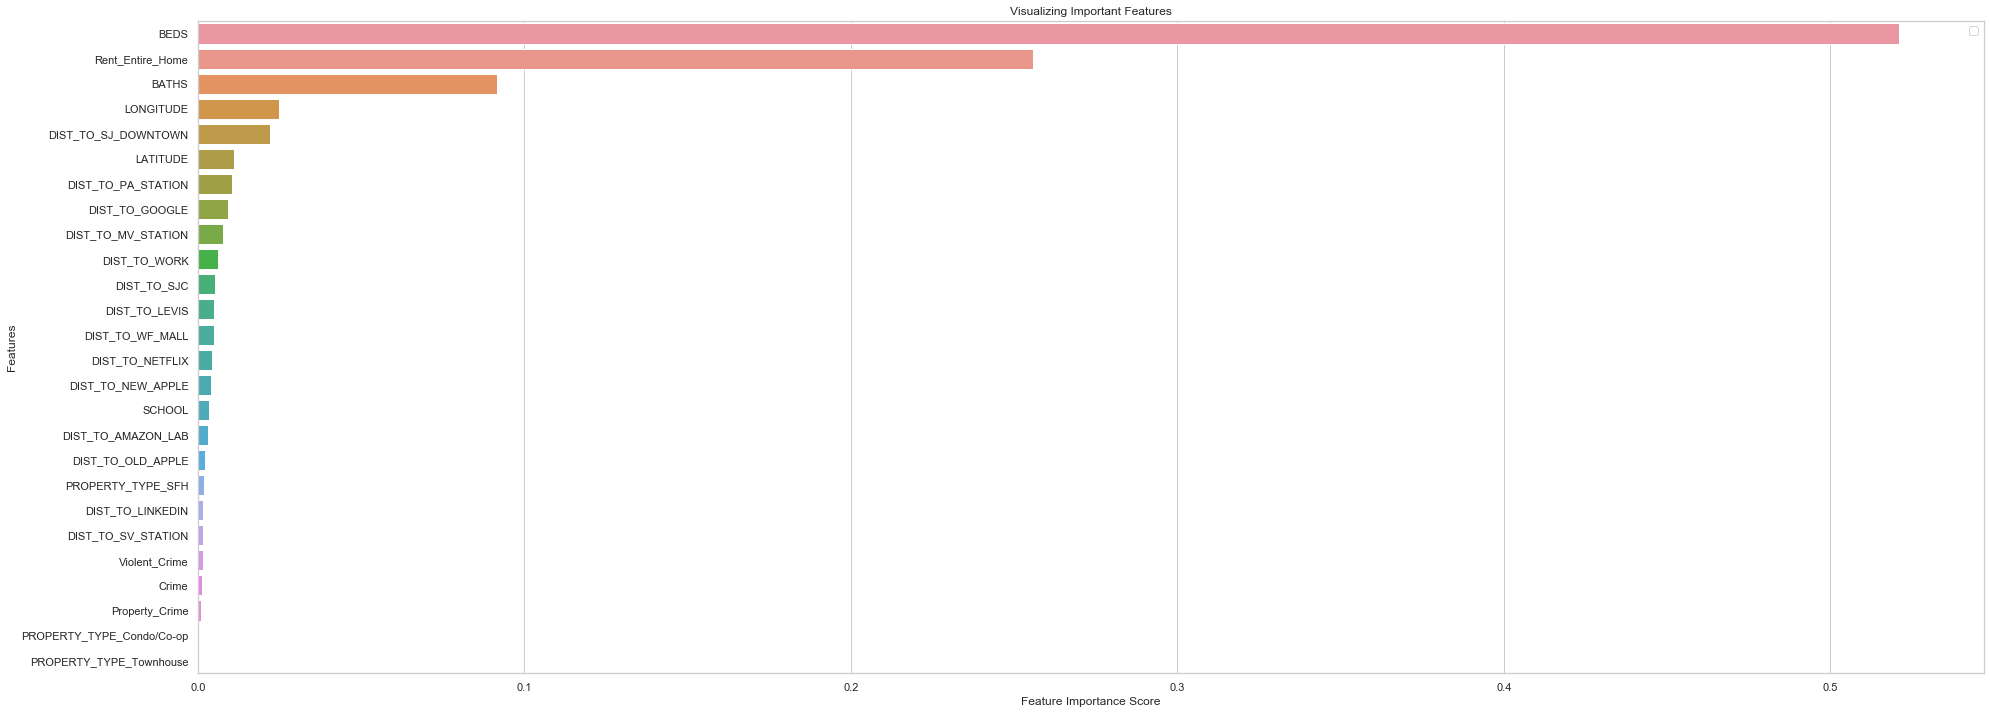

In [104]:
feature_imp_airbnb = pd.Series(rfr_airbnb.feature_importances_,index=predictors_airbnb).sort_values(ascending=False)
plt.figure(figsize=(32, 12))
sns.barplot(x=feature_imp_airbnb, y=feature_imp_airbnb.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Relationship between Original and Predicted Price')

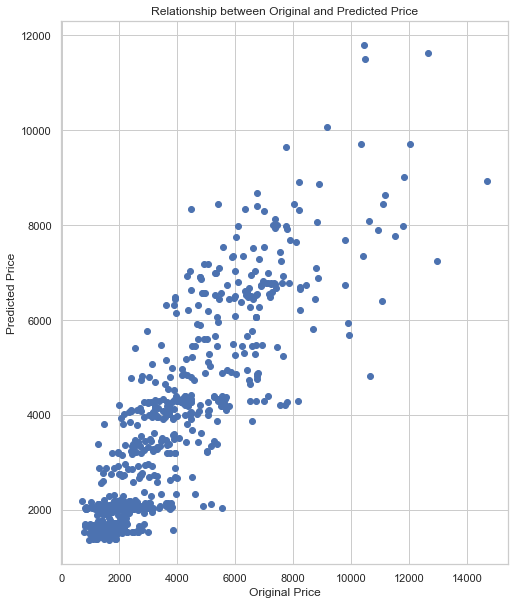

In [105]:
#Fitted vs. Original

#Homes with price > $5mm show big errors
plt.scatter(y_true_airbnb, y_pred_airbnb)
plt.xlabel("Original Price")
plt.ylabel("Predicted Price")
plt.title("Relationship between Original and Predicted Price")

Text(0.5, 1.0, 'Relationship between Residuals and Fitted Values')

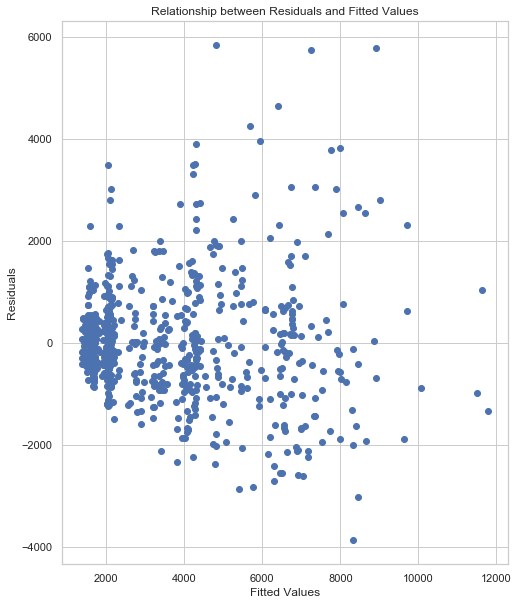

In [106]:
#Residuals vs. Fitted

residuals_airbnb = y_test_airbnb['monthly_rent'].to_numpy() - y_pred_airbnb

plt.scatter(y_pred_airbnb, residuals_airbnb)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Relationship between Residuals and Fitted Values")

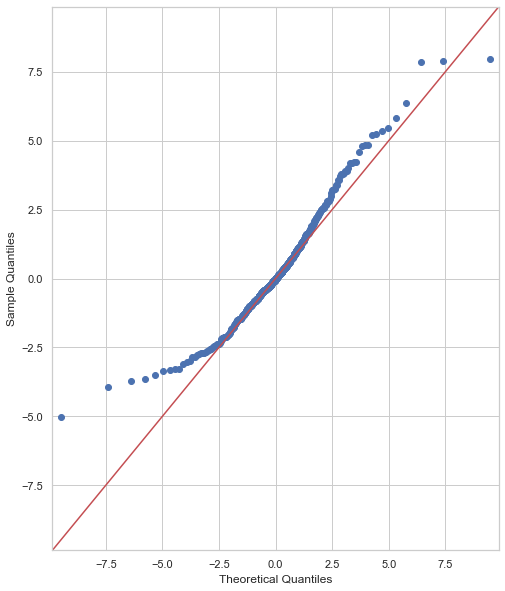

In [107]:
#QQ Plot
import statsmodels.api as sm
import scipy.stats as stats

fig = sm.qqplot(residuals_airbnb, stats.t, fit=True, line='45')
plt.show()

In [108]:
#Prediction

y_pred_redfin_all =rfr_redfin.predict(X_redfin)

redfin['pred_home_price'] = y_pred_redfin_all


In [109]:
#Reduce the redfin features to the list of airbnb features and predict rental income
redfin_rental_features = ['BEDS','BATHS','LATITUDE','LONGITUDE',
                 'DIST_TO_GOOGLE','DIST_TO_OLD_APPLE','DIST_TO_NEW_APPLE',
                 'DIST_TO_PA_STATION','DIST_TO_MV_STATION','DIST_TO_SV_STATION','DIST_TO_WF_MALL',
                 'DIST_TO_NETFLIX','DIST_TO_SJ_DOWNTOWN','DIST_TO_LINKEDIN','DIST_TO_AMAZON_LAB',
                 'DIST_TO_LEVIS','DIST_TO_SJC','SCHOOL','Violent_Crime','Property_Crime',
                 'Crime','DIST_TO_WORK','PROPERTY_TYPE_Condo/Co-op','PROPERTY_TYPE_SFH',
                 'PROPERTY_TYPE_Townhouse']

X_redfin_reduced = redfin.loc[:,redfin_rental_features]

#Change this feature's value to see rental income if the entire home is rented or not
rent_entire_home = 1

X_redfin_reduced['Rent_Entire_Home']=rent_entire_home

In [110]:
y_redfin_pred_rental =rfr_airbnb.predict(X_redfin_reduced)
redfin['pred_rental_price'] = y_redfin_pred_rental

In [111]:
#Check out: roofstock.com
#https://learn.roofstock.com/blog/calculate-roi-on-rental-property
    
#Investment for Cash Flows

#Assumes no vacancy with the predicted daily airbnb price

#This is an aggressive assumption, limit the airbnb data to no vacancy observations?
#Also, there's monthly price in the airbnb data (very few observations tho)
#Or, use the actual monthly rental estimate from Zillow

#The actual ROI should subtract any costs during the year including 
#taxes, maintainance, hoa, utilities, insurance, property management fees
#Closing costs, repairs and remodelling costs should be subtracted from the initial investment

#This is assuming the house is bought in cash with no mortgages, if not subtract the monthly mortgages
#Some people add the equity each year into income but keep in mind that it's not realized unless you sell it or HELOC it

#This is assuming no appreciation of the home, if not add it to the equity but again won't realize it untill you sell it

#Capitalization rate(cap rate) doesn't consider mortgages and use total home price instead of initial cash
#Cap rate = NOI x 12 months / purchase price
#NOI = (rental income + other income) - vacancy losses and operating expenses
redfin['Cap_Rate']=redfin['pred_rental_price'] * 12 / redfin['pred_home_price']

redfin = redfin.sort_values('Cap_Rate',ascending=False )

In [112]:
#The median cap rate is 7.4%
#Using this model, we can find the deals of investment properties by sorting ROI
redfin.quantile([.01, .1, .25, .5, .75, .9, .99])['Cap_Rate']

0.01    0.036587
0.10    0.047680
0.25    0.059446
0.50    0.074703
0.75    0.094862
0.90    0.116266
0.99    0.161146
Name: Cap_Rate, dtype: float64

In [113]:
cap_rate_median = redfin['Cap_Rate'].quantile(.5)
cap_rate_75th = redfin['Cap_Rate'].quantile(.75)
cap_rate_25th = redfin['Cap_Rate'].quantile(.25)

#Categorize properies into 
#Great Deals: if above 75th percentile
#Deals: if between 50th and 75th percentiles
#Not Deals: if below 50th percentile
redfin['Deal'] = 'Not a Deal'
redfin.loc[(redfin['Cap_Rate']>cap_rate_median) & (redfin['Cap_Rate']<=cap_rate_75th), 'Deal'] = 'Deal'
redfin.loc[redfin['Cap_Rate']>cap_rate_75th, 'Deal'] = 'A Great Deal'

In [114]:
#List of homes which are great deals
redfin.loc[redfin['Deal'] == 'A Great Deal',:]

PRICE  BEDS  BATHS  SQUARE_FEET  LOT_SIZE    YEAR  HOA/MONTH  \
4966    475000.0   3.0    2.0       1141.0    1035.0  1987.0      270.0   
4977    530000.0   3.0    2.0       1118.0    1144.0  1987.0      257.0   
8651    510000.0   3.0    2.0       1145.0    1160.0  1976.0      285.0   
5232    550000.0   4.0    2.0       1152.0    7475.0  1975.0      117.0   
5078    555000.0   4.0    2.5       1588.0    6000.0  1978.0      117.0   
5053    635000.0   5.0    3.0       1858.0    6120.0  1975.0      117.0   
5043    580000.0   4.0    2.0       1157.0    5500.0  1983.0      117.0   
5012    565000.0   3.0    2.5       1663.0    1725.0  1985.0      341.0   
4992    559990.0   3.0    2.5       1663.0    2067.0  1985.0      360.0   
5077    516000.0   3.0    2.0       1293.0    1293.0  2003.0      235.0   
5058    652000.0   5.0    3.0       1948.0    5120.0  1987.0      165.0   
5016    470000.0   3.0    1.5       1265.0     435.0  1986.0      220.0   
5014    565000.0   3.0    2.0       1271.0    2100.0  1974.0      205.0   
5003    560000.0   3.0    2.5       1663.0    1774.0  1985.0      360.0   
5233    627000.0   4.0    2.0       1157.0    5732.0  1983.0      117.0   
5213    588500.0   3.0    3.0       1568.0    4292.0  1991.0      117.0   
4989    590000.0   3.0    2.5       1663.0    1775.0  1985.0      235.0   
5158    628000.0   4.0    2.0       1256.0    4981.0  1979.0      117.0   
5082    620000.0   4.0    3.0       1961.0    2721.0  2005.0      112.0   
5009    610000.0   4.0    2.5       1679.0    2644.0  2007.0      190.0   
4991    632000.0   4.0    2.5       1679.0    2527.0  2007.0      190.0   
8549    485000.0   3.0    1.5       1145.0    1160.0  1976.0      280.0   
23398   530000.0   4.0    2.5       1474.0     966.0  1977.0      238.0   
8569    490000.0   3.0    1.5       1145.0    1160.0  1976.0      285.0   
4981    590000.0   3.0    2.5       1663.0    2711.0  1985.0      345.0   
5089    620000.0   4.0    2.0       1209.0    7280.0  1976.0      117.0   
5112    660000.0   5.0    2.5       2057.0    5938.0  1963.0      117.0   
5001    600000.0   3.0    2.5       1663.0    1770.0  1985.0      341.0   
4990    555000.0   3.0    2.0       1271.0    3059.0  1974.0      195.0   
5084    615000.0   3.0    3.0       1568.0    4736.0  1991.0      117.0   
...          ...   ...    ...          ...       ...     ...        ...   
7232    548500.0   2.0    1.0        934.0     954.0  1987.0      436.0   
13442   665000.0   3.0    1.0        960.0    5318.0  1959.0      117.0   
12970   825000.0   3.0    2.0       1232.0    5995.0  1967.0      117.0   
17523   875000.0   3.0    3.0       1311.0    1581.0  2007.0      282.0   
9491   1510000.0   4.0    2.5       2062.0  102956.0  1976.0      117.0   
9212   1199000.0   3.0    3.5       2337.0   30241.0  1995.0      117.0   
23893  1200000.0   4.0    2.5       1693.0    8131.0  1992.0      117.0   
7991    800777.0   2.0    2.0       1309.0     435.0  2007.0      489.0   
13408   680000.0   3.0    1.0        960.0    4998.0  1959.0      117.0   
14548  1008000.0   4.0    2.0       1450.0    5979.0  1962.0      117.0   
13870   395000.0   1.0    1.0        722.0     717.0  1970.0      373.0   
14652  1030000.0   4.0    2.0       1516.0    6108.0  1963.0      117.0   
17119   936000.0   4.0    2.0       2206.0    6098.0  1986.0      117.0   
18636   900000.0   3.0    2.5       1758.0    3500.0  1980.0      370.0   
14616  1080000.0   4.0    2.0       1345.0    5941.0  1966.0      117.0   
12212   930000.0   3.0    2.5       1673.0    1989.0  1989.0      400.0   
17570   725000.0   2.0    2.5       1122.0    1120.0  2005.0      425.0   
439     950000.0   2.0    2.0       1067.0     968.0  1971.0      370.0   
23499   650000.0   3.0    1.0        888.0    5360.0  1950.0      117.0   
9311   1135000.0   3.0    3.0       2500.0  871200.0  1982.0      117.0   
23746   868000.0   3.0    2.5       1371.0    3400.0  1989.0      117.0   
13358   835000.0   3.0    2.0       

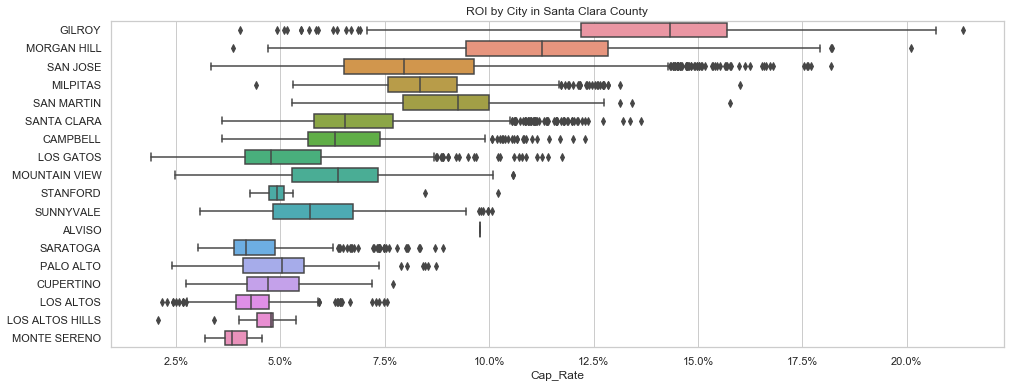

In [142]:
#Cap Rate by city

#redfin['Cap_Rate'] = redfin['Cap_Rate']*100
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="Cap_Rate", y="city", orient="h", data=redfin)
#ax = sns.swarmplot(x="PRICE", y="CITY", orient="h", data=redfin, color="white")
ax.set_title("ROI by City in Santa Clara County")
ax.set_ylabel('')

import matplotlib.ticker as mtick

# Actual plotting code omitted

ax.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [115]:
#Some checking
#Best deals seem to be neighborhoods which you can buy a large house with low purchase price
#and get a decent rental price

#Cap rate by city
Cap_rate_by_city = redfin.groupby('city')['pred_home_price','pred_rental_price','Cap_Rate','SCHOOL',
                       'Crime','DIST_TO_WORK','SQUARE_FEET'].median()
Cap_rate_by_city = Cap_rate_by_city.sort_values('Cap_Rate',ascending=False )
Cap_rate_by_city

pred_home_price  pred_rental_price  Cap_Rate     SCHOOL  \
city                                                                       
GILROY              7.640904e+05        9495.232867  0.143406  45.789375   
MORGAN HILL         9.489890e+05        9958.065762  0.112637  44.907917   
ALVISO              1.053686e+06        8579.664876  0.097710  49.055000   
SAN MARTIN          1.171979e+06        9593.704084  0.092621  22.965000   
MILPITAS            1.042830e+06        7259.681747  0.083340  60.954231   
SAN JOSE            1.029681e+06        6929.191015  0.079634  45.384062   
SANTA CLARA         1.323292e+06        7290.696304  0.065567  51.005000   
MOUNTAIN VIEW       1.590500e+06        8583.451428  0.063710  63.857500   
CAMPBELL            1.356935e+06        7139.442068  0.063172  52.326667   
SUNNYVALE           1.551407e+06        7706.213814  0.057225  54.488750   
PALO ALTO           2.296083e+06        8880.452776  0.050435  81.320625   
STANFORD            2.590405e+06       10494.093988  0.049141  78.440000   
LOS ALTOS HILLS     2.613927e+06       10738.150069  0.047812  83.516667   
LOS GATOS           1.821331e+06        7467.835033  0.047758  79.493750   
CUPERTINO           2.061408e+06        7837.770433  0.047024  85.640714   
LOS ALTOS           2.573194e+06        9183.238146  0.042944  88.424000   
SARATOGA            2.364696e+06        8211.035739  0.041864  84.479444   
MONTE SERENO        2.449263e+06        7911.048131  0.038358  73.388333   

                 Crime  DIST_TO_WORK  SQUARE_FEET  
city                                               
GILROY           36.20     37.646244       2032.5  
MORGAN HILL      19.70     30.388884       2194.5  
ALVISO           28.60      7.682051       1981.0  
SAN MARTIN       24.00     33.708704       2130.0  
MILPITAS         25.40     10.946585       1457.5  
SAN JOSE         27.15     14.044719       1503.0  
SANTA CLARA      24.60      7.472668       1399.0  
MOUNTAIN VIEW    32.05      4.825010       1342.0  
CAMPBELL         31.40     10.682631       1545.0  
SUNNYVALE        23.95      5.386494       1488.0  
PALO ALTO        23.05      5.545743       1392.0  
STANFORD         23.35      6.253422       2045.0  
LOS ALTOS HILLS   8.25      6.343021       2316.0  
LOS GATOS        20.25     13.003851       1992.0  
CUPERTINO        16.00      6.726697       1660.0  
LOS ALTOS         5.45      5.558674       1728.0  
SARATOGA          7.45      9.412613       2229.0  
MONTE SERENO     14.65     12.382648       2366.0

In [123]:
from bokeh.plotting import figure
from bokeh.io import show, save, output_notebook, output_file
from bokeh.plotting import ColumnDataSource
from bokeh.models import HoverTool, LabelSet

source = ColumnDataSource(Cap_rate_by_city)

p = figure(title = 'Property Rental Income vs. Purchase Price',
           x_axis_label = 'Property Purchase Price', 
           y_axis_label = 'Property Rental Monthly Rental Income')

p.circle('pred_home_price', 'pred_rental_price', size=10, source=source,
        fill_color='red', alpha=0.8, line_color=None,
         hover_fill_color='firebrick', hover_alpha=0.5,
         hover_line_color='white')

labels = LabelSet(x='pred_home_price', y='pred_rental_price', text='city', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

p.add_layout(labels)

hover = HoverTool(tooltips='@city')
p.add_tools(hover)


output_notebook()

show(p)

Loading BokehJS ...

In [126]:
from bokeh.layouts import row, column, gridplot

hover = HoverTool(tooltips='@city')

labels = LabelSet(x='School', y='Cap Rate', text='city', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

p1 = figure(title = 'Cap Rate vs. School', 
            x_axis_label = 'School', 
            y_axis_label = 'Cap Rate')

p1.circle('SCHOOL', 'Cap_Rate', size=10, source=source,
         fill_color='red', alpha=0.8, line_color=None,
         hover_fill_color='firebrick', hover_alpha=0.5,
         hover_line_color='white')
p1.add_layout(labels)

p1.add_tools(hover)

p2 = figure(title = 'Cap Rate vs. Crime', 
            x_axis_label = 'Crime', 
            y_axis_label = 'Cap Rate')

p2.circle('Crime', 'Cap_Rate', size=10, source=source,
         fill_color='blue', alpha=0.8, line_color=None,
         hover_fill_color='firebrick', hover_alpha=0.5,
         hover_line_color='white')
p2.add_tools(hover)

p3 = figure(title = 'Cap Rate vs. Distance to Work', 
            x_axis_label = 'Distance to Work', 
            y_axis_label = 'Cap Rate')

p3.circle('DIST_TO_WORK', 'Cap_Rate', size=10, source=source,
         fill_color='green', alpha=0.8, line_color=None,
         hover_fill_color='firebrick', hover_alpha=0.5,
         hover_line_color='white')
p3.add_tools(hover)

p4 = figure(title = 'Cap Rate vs. Square Feet', 
            x_axis_label = 'Square Feet', 
            y_axis_label = 'Cap Rate')

p4.circle('SQUARE_FEET', 'Cap_Rate', size=10, source=source,
         fill_color='orange', alpha=0.8, line_color=None,
         hover_fill_color='firebrick', hover_alpha=0.5,
         hover_line_color='white')
p4.add_tools(hover)

row1 = [p1,p2]
row2 = [p3,p4]
layout = gridplot([row1, row2],sizing_mode='scale_width')

output_notebook()

show(layout)

Loading BokehJS ...

C:\Users\armcl\Anaconda3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


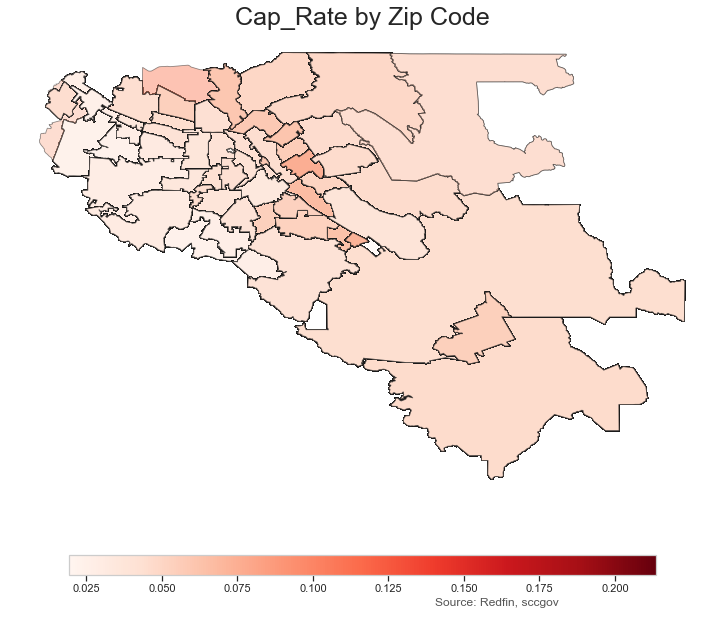

In [125]:
#Let's make a map!
import geopandas as gpd

#Santa Clara County shape file by zip code
map_df = gpd.read_file(data_path + "ba_map/zipcode_scc/Zip_Codes.shp")


redfin['zipcode'] = redfin['zipcode'].astype(str)

map_df = map_df.drop(columns=['LATITUDE','LONGITUDE'])

merged = map_df.set_index('ZCTA').join(redfin.set_index('zipcode'))

variable = 'Cap_Rate'

# set the range for the choropleth values
vmin, vmax = redfin['Cap_Rate'].min(), redfin['Cap_Rate'].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(variable + ' by Zip Code', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: Redfin, sccgov', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# add the colorbar to the figure
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)

# create map
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax,
           alpha=0.5, edgecolor='k')


In [ ]:
#Use zillow rental index (ZRI) data (long-term rental) to verify if the results make sense
#Note that the zillow rental list price are medians by zipcode it's not personalized for individual homes
#The results confirm the story: avoid nice neighborhood

ZRI = pd.read_csv(data_path + "Zillow/ZRI.csv")

#Get median house price per zipcode using the redfin data
redfin_median_price = pd.read_csv(data_path + "redfin_clean_scc.csv")

redfin_median_price = redfin_median_price.groupby('ZIP OR POSTAL CODE').median()

redfin_median_price['zipcode_redfin'] = redfin_median_price.index

#Merge the two data to get the median cap rate per zipcode
median_cap_rate_zipcode = pd.merge(redfin_median_price, ZRI, left_index=True, 
                      right_on='RegionName', how='left')

median_cap_rate_zipcode['Cap_Rate'] = median_cap_rate_zipcode['Zri']*12/median_cap_rate_zipcode['PRICE']

columns = ['RegionName','City','PRICE','Zri','Cap_Rate','MoM','YoY','SizeRank','BEDS','BATHS',
           'SQUARE FEET','LOT SIZE','YEAR BUILT','sale_num_zip','Percentage Standard Met and Above',
          'Crime']
median_cap_rate_zipcode = median_cap_rate_zipcode.loc[:,columns]
median_cap_rate_zipcode = median_cap_rate_zipcode.sort_values('Cap_Rate',ascending=False )

Cap_rate_by_city_zri = median_cap_rate_zipcode.groupby('City').median()[['Cap_Rate']]
Cap_rate_by_city_zri = Cap_rate_by_city_zri.sort_values('Cap_Rate',ascending=False )
Cap_rate_by_city_zri

In [ ]:
#Using a rental price data with more granularity: rental per sqft for 3bed
#This confirms our story again

rent_per_sqft_3beds = pd.read_csv(data_path + "Zillow/Rent_Per_Sqft_3Bed.csv")
redfin_3bedsf = redfin.loc[redfin['BEDS']==3,:]

rent_per_sqft_3beds['RegionName']=rent_per_sqft_3beds['RegionName'].astype('str')

merged_3beds = pd.merge(redfin_3bedsf, rent_per_sqft_3beds, left_on='zipcode', 
                      right_on='RegionName', how='right')
merged_3beds['zillow_3beds_rent'] = merged_3beds['Rent_Per_SQFT'] * merged_3beds['SQUARE_FEET']

merged_3beds['cap_rate_zillow3beds'] = merged_3beds['zillow_3beds_rent']*12/merged_3beds['PRICE']

merged_3beds = merged_3beds.sort_values('cap_rate_zillow3beds',ascending=False )


Cap_rate_by_city_zri3beds = merged_3beds.groupby('City').median()[['cap_rate_zillow3beds']]
Cap_rate_by_city_zri3beds = Cap_rate_by_city_zri3beds.sort_values('cap_rate_zillow3beds',ascending=False )
Cap_rate_by_city_zri3beds

In [ ]:
#So what about home price appreciation?
#That will be another great project but just from observations
#Nice neighborhoods prices are less volatile so they hold price better during the down term
#But that also means it appreciates less in % terms
#So it depends on your risk tolerence!